# Analiza danych Airbnb - Winnipeg
## Zadaniem jest przeanalizowanie – z użyciem środowiska i bibliotek języka R – jednego ze zbiorów danych, dotyczących wynajmu lokali poprzez platformę Airbnb (http://insideairbnb.com/get-the-data.html).



### Zadanie 1: Poprawne załadowanie danych
Poprawne załadowanie danych ze źródła internetowego do ramki danych, z uwzględnieniem nagłówków, kodowania zbioru, separatorów itd.

In [3]:
# Instalacja i ładowanie wymaganych pakietów
install.packages(c(
  "tidyverse",      # Zawiera: dplyr, ggplot2, tidyr, readr, stringr
  "lubridate",      # Operacje na datach
  "corrplot",       # Macierze korelacji
  "VIM",            # Wizualizacja braków
  "mice",           # Imputacja MICE
  "gridExtra",      # Układanie wykresów
  "scales",         # Formatowanie osi
  "psych",          # Skośność, kurtoza
  "car",            # Test Levene'a
  "GGally",         # Pair plots
  "leaflet",        # Mapy interaktywne
  "htmlwidgets",    # Zapis map HTML
  "tidytext",       # Analiza tekstu
  "ggrepel"         # Etykiety bez nachodzenia
), repos = "http://cran.us.r-project.org")

# Ładowanie bibliotek
suppressPackageStartupMessages({
  library(tidyverse)
  library(lubridate)
  library(corrplot)
  library(VIM)
  library(mice)
  library(gridExtra)
  library(scales)
  library(psych)
  library(car)
  library(GGally)
  library(leaflet)
  library(htmlwidgets)
  library(tidytext)
  library(ggrepel)
})

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ucminf’, ‘rbibutils’, ‘zoo’, ‘iterators’, ‘ordinal’, ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘DEoptimR’, ‘lmtest’, ‘proxy’, ‘RcppEigen’, ‘foreach’, ‘shape’, ‘pan’, ‘jomo’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘patchwork’, ‘lazyeval’, ‘terra’, ‘SnowballC’, ‘colorspace’, ‘robustbase’, ‘sp’, ‘vcd’, ‘e1071’, ‘laeken’, ‘ranger’, ‘glmnet’, ‘mitml’, ‘mnormt’, ‘GPArotation’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘ggstats’, ‘plyr’, ‘crosstalk’, ‘leaflet.providers’, ‘png’, ‘raster’, ‘janeaustenr’, ‘tokenizers’




In [198]:
# Ustawienia globalne
options(scipen = 999)
dir.create("wykresy_prezentacja", showWarnings = FALSE)

# ZAŁADOWANIE DANYCH Z WINNIPEG
cat("\n=== ZAŁADOWANIE DANYCH AIRBNB WINNIPEG ===\n")

# URL do danych Winnipeg
url <- "https://data.insideairbnb.com/canada/mb/winnipeg/2025-03-07/data/listings.csv.gz"

# Załadowanie danych z obsługą kodowania UTF-8
df <- read_csv(
  url,
  col_types = cols(),
  locale = locale(encoding = "UTF-8"),
  na = c("", "NA", "N/A", "null"),
  show_col_types = FALSE
)

cat("✓ Dane załadowane pomyślnie!\n")
cat("✓ Źródło: Winnipeg, Manitoba, Kanada\n")
cat("✓ Data pobrania:", format(Sys.Date(), "%d-%m-%Y"), "\n")


=== ZAŁADOWANIE DANYCH AIRBNB WINNIPEG ===
✓ Dane załadowane pomyślnie!
✓ Źródło: Winnipeg, Manitoba, Kanada
✓ Data pobrania: 14-06-2025 


### Zadanie 2: Poznanie rozmiaru zbioru danych
Poznanie rozmiaru zbioru danych (liczby obserwacji i liczby zmiennych, które je opisują) i oszacowanie czasochłonności

In [199]:
# ANALIZA ROZMIARU ZBIORU I CZASOCHŁONNOŚCI
cat("\n=== ROZMIAR ZBIORU DANYCH ===\n")

# Podstawowe informacje o zbiorze
n_rows <- nrow(df)
n_cols <- ncol(df)
memory_size <- object.size(df)

cat("Liczba obserwacji (wierszy):", format(n_rows, big.mark = ","), "\n")
cat("Liczba zmiennych (kolumn):", n_cols, "\n")
cat("Rozmiar w pamięci:", format(memory_size, units = "MB"), "\n")

# Oszacowanie czasochłonności operacji
cat("\n=== OSZACOWANIE CZASOCHŁONNOŚCI ===\n")

# Test na próbce 100 obserwacji
sample_size <- min(100, n_rows)
sample_df <- df[1:sample_size, ]

# Pomiar czasu różnych operacji
operations <- list(
  "Statystyki opisowe" = function(x) summary(x),
  "Macierz korelacji" = function(x) cor(select_if(x, is.numeric), use = "complete.obs"),
  "Grupowanie danych" = function(x) x %>% group_by(room_type) %>% summarise(n = n()),
  "Tworzenie wykresu" = function(x) ggplot(x, aes(x = price)) + geom_histogram()
)

# Testowanie czasów wykonania
time_estimates <- data.frame()
for(op_name in names(operations)) {
  op_time <- system.time({
    suppressWarnings(suppressMessages(operations[[op_name]](sample_df)))
  })[3]

# Ekstrapolacja na pełny zbiór
estimated_full_time <- op_time * n_rows / sample_size

  time_estimates <- rbind(time_estimates,
                         data.frame(
                           Operacja = op_name,
                           Czas_probki_s = round(op_time, 3),
                           Szacowany_czas_pelny_s = round(estimated_full_time, 2)
                         ))
}

print(time_estimates)


=== ROZMIAR ZBIORU DANYCH ===
Liczba obserwacji (wierszy): 1,626 
Liczba zmiennych (kolumn): 79 
Rozmiar w pamięci: 4.2 Mb 

=== OSZACOWANIE CZASOCHŁONNOŚCI ===
                   Operacja Czas_probki_s Szacowany_czas_pelny_s
elapsed  Statystyki opisowe         0.036                   0.59
elapsed1  Macierz korelacji         0.054                   0.88
elapsed2  Grupowanie danych         0.011                   0.18
elapsed3  Tworzenie wykresu         0.006                   0.10


### Zadanie 3: Wyświetlenie próbki surowych danych
Wyświetlenie próbki surowych danych w celu wyrobienia sobie wyobrażenia o nich – poznania struktury danych i wstępnej oceny przydatności poszczególnych zmiennych.


In [200]:
# EKSPLORACJA SUROWYCH DANYCH
cat("\n=== PRÓBKA SUROWYCH DANYCH ===\n")

# Lista wszystkich kolumn
cat("\n📋 WSZYSTKIE KOLUMNY (", n_cols, "):\n", sep = "")
cat(paste(names(df), collapse = ", "), "\n")

# Kluczowe kolumny do analizy
key_columns <- c("id", "name", "price", "room_type", "property_type",
                "accommodates", "bedrooms", "beds", "bathrooms_text",
                "neighbourhood_cleansed", "review_scores_rating",
                "host_is_superhost", "minimum_nights")

# Sprawdź które kolumny istnieją
available_key_cols <- key_columns[key_columns %in% names(df)]

cat("\n📌 PIERWSZE 5 WIERSZY (wybrane kluczowe kolumny):\n")
print(head(df[, available_key_cols], 5))

cat("\n📌 LOSOWE 5 WIERSZY:\n")
set.seed(123)  # Dla powtarzalności
random_indices <- sample(n_rows, min(5, n_rows))
print(df[random_indices, available_key_cols])

cat("\n📌 OSTATNIE 5 WIERSZY:\n")
print(tail(df[, available_key_cols], 5))

# Struktura danych
cat("\n📌 STRUKTURA DANYCH (pierwsze 10 kolumn):\n")
str(df[, 1:min(10, ncol(df))])


=== PRÓBKA SUROWYCH DANYCH ===

📋 WSZYSTKIE KOLUMNY (79):
id, listing_url, scrape_id, last_scraped, source, name, description, neighborhood_overview, picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bathrooms_text, bedrooms, beds, amenities, price, minimum_nights, maximum_nights, minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, calendar_updated, has_availability, availability_30, availability_60, availability_90, availability_365, calendar_last_scraped, number_of_reviews, 

### Zadanie 4: Weryfikacja typów zmiennych
Weryfikacja typów poszczególnych zmiennych (całkowite, zmiennoprzecinkowe, kategoryczne porządkowe, kategoryczne nominalne, zmienne typu logicznego, daty) i ich ewentualna korekta.

In [224]:
# WERYFIKACJA I KONWERSJA TYPÓW ZMIENNYCH
cat("\n=== WERYFIKACJA TYPÓW ZMIENNYCH ===\n")

# Sprawdź typy przed
cat("TYPY ZMIENNYCH PRZED KONWERSJĄ:\n")
types_before <- df %>%
  summarise_all(~class(.)[1]) %>%
  gather(key = "Kolumna", value = "Typ") %>%
  count(Typ) %>%
  arrange(desc(n))
print(types_before)

# KONWERSJA
cat("\nKONWERSJA TYPÓW ZMIENNYCH...\n")

df <- df %>%
  mutate(
    # NUMERYCZNE - konwersja cen (z tekstu "$75.00" na 75)
    price = as.numeric(gsub("[$,]", "", price)),

    # DATY (z tekstu na Date)
    host_since = as.Date(host_since),
    first_review = as.Date(first_review),
    last_review = as.Date(last_review),

    # NUMERYCZNE - procenty (z "98%" na 0.98)
    host_response_rate = as.numeric(gsub("%", "", host_response_rate)) / 100,
    host_acceptance_rate = as.numeric(gsub("%", "", host_acceptance_rate)) / 100,

    # KATEGORYCZNE (z character na factor)
    room_type = as.factor(room_type),
    property_type = as.factor(property_type),
    neighbourhood_cleansed = as.factor(neighbourhood_cleansed),

    # KATEGORYCZNE PORZĄDKOWE
    host_response_time = factor(host_response_time,
                               levels = c("within an hour", "within a few hours",
                                        "within a day", "a few days or more"),
                               ordered = TRUE),

    # NUMERYCZNE - wyodrębnienie liczby z tekstu
    bathrooms_numeric = as.numeric(str_extract(bathrooms_text, "\\d+\\.?\\d*"))
  )

# Sprawdź typy po
cat("\nTYPY ZMIENNYCH PO KONWERSJI:\n")
types_after <- df %>%
  summarise_all(~class(.)[1]) %>%
  gather(key = "Kolumna", value = "Typ") %>%
  count(Typ) %>%
  arrange(desc(n))
print(types_after)



=== WERYFIKACJA TYPÓW ZMIENNYCH ===
TYPY ZMIENNYCH PRZED KONWERSJĄ:
# A tibble: 6 × 2
  Typ           n
  <chr>     <int>
1 numeric      62
2 character    18
3 Date          5
4 logical       5
5 factor        3
6 ordered       1

KONWERSJA TYPÓW ZMIENNYCH...

TYPY ZMIENNYCH PO KONWERSJI:
# A tibble: 6 × 2
  Typ           n
  <chr>     <int>
1 numeric      62
2 character    18
3 Date          5
4 logical       5
5 factor        3
6 ordered       1


### Zadanie 5: Podsumowanie zmiennych
Zbudowanie podsumowania zmiennych numerycznych opisujących zbiór, w postaci jednej tabelki oraz analogiczna analiza zmiennych kategorycznych.

In [225]:
# PODSUMOWANIE ZMIENNYCH NUMERYCZNYCH I KATEGORYCZNYCH
cat("\n=== PODSUMOWANIE ZMIENNYCH ===\n")

# A. ZMIENNE NUMERYCZNE - JEDNA TABELKA
cat("\nPODSUMOWANIE ZMIENNYCH NUMERYCZNYCH:\n")

# Wybór głównych zmiennych numerycznych
numeric_vars <- c("price", "accommodates", "bedrooms", "beds", "bathrooms_numeric",
                 "minimum_nights", "maximum_nights", "number_of_reviews",
                 "reviews_per_month", "availability_365", "review_scores_rating")

# Filtruj tylko istniejące zmienne
numeric_vars <- numeric_vars[numeric_vars %in% names(df)]

# Funkcja do obliczania wszystkich statystyk
calc_all_stats <- function(x) {
  if(!is.numeric(x)) {
    return(c(Min = NA, Max = NA, Srednia = NA, Mediana = NA,
             Q1 = NA, Q3 = NA, SD = NA, Braki = NA))
  }

  stats <- c(
    Min = min(x, na.rm = TRUE),
    Max = max(x, na.rm = TRUE),
    Srednia = mean(x, na.rm = TRUE),
    Mediana = median(x, na.rm = TRUE),
    Q1 = quantile(x, 0.25, na.rm = TRUE)[[1]],
    Q3 = quantile(x, 0.75, na.rm = TRUE)[[1]],
    SD = sd(x, na.rm = TRUE),
    Braki = sum(is.na(x))
  )

  return(stats)
}

# Utworzenie jednej tabelki
numeric_summary <- data.frame(
  Zmienna = numeric_vars,
  t(sapply(df[numeric_vars], calc_all_stats)),
  row.names = NULL
)

# Zaokrąglenie wartości
numeric_cols <- setdiff(names(numeric_summary), c("Zmienna", "Braki"))
numeric_summary[numeric_cols] <- round(numeric_summary[numeric_cols], 2)
numeric_summary$Braki <- as.integer(numeric_summary$Braki)

print(numeric_summary)

# B. ZMIENNE KATEGORYCZNE
cat("\nPODSUMOWANIE ZMIENNYCH KATEGORYCZNYCH:\n")

categorical_vars <- c("room_type", "property_type", "neighbourhood_cleansed",
                     "host_response_time", "host_is_superhost", "instant_bookable")

for(var in categorical_vars) {
  if(var %in% names(df)) {
    cat("\n➤", var, ":\n")

    # Tabela częstości
    freq_table <- table(df[[var]], useNA = "ifany")

    # Statystyki
    cat("  • Liczba kategorii:", length(freq_table), "\n")
    cat("  • Wartość najczęstsza:", names(which.max(freq_table)),
        "(", max(freq_table), " wystąpień =",
        round(max(freq_table)/n_rows*100, 1), "%)\n", sep="")
    cat("  • Liczba unikalnych:", length(unique(df[[var]])), "\n")
    cat("  • Liczba braków:", sum(is.na(df[[var]])), "\n")

    # Top 5 kategorii
    if(length(freq_table) > 5) {
      cat("  • Top 5 kategorii:\n")
      top5 <- sort(freq_table, decreasing = TRUE)[1:5]
      for(i in 1:5) {
        cat("    -", names(top5)[i], ":", top5[i], "\n")
      }
    }
  }
}
# Szybkie podsumowanie superhostów
cat("\nSUPERHOŚCI:\n")
cat(sprintf("• Superhostów: %d (%.1f%%)\n",
            sum(df$host_is_superhost, na.rm = TRUE),
            mean(df$host_is_superhost, na.rm = TRUE) * 100))

cat("\n✓ Konwersja zakończona!\n")


=== PODSUMOWANIE ZMIENNYCH ===

PODSUMOWANIE ZMIENNYCH NUMERYCZNYCH:
                Zmienna   Min     Max Srednia Mediana    Q1     Q3     SD Braki
1                 price 30.52  519.48  106.43   89.00 64.00 124.00  71.60     0
2          accommodates  1.00   16.00    3.65    4.00  2.00   4.00   2.09     0
3              bedrooms  0.00    6.00    1.75    2.00  1.00   2.00   0.96     0
4                  beds  0.00   12.00    1.92    2.00  1.00   2.00   1.19     0
5     bathrooms_numeric  0.00    5.00    1.29    1.00  1.00   1.50   0.58     4
6        minimum_nights  1.00   45.44    6.98    2.00  1.00   3.00  11.17     0
7        maximum_nights  5.52 1125.00  411.36  365.00 30.00 365.00 386.91     0
8     number_of_reviews  0.00  844.00   49.58   20.00  4.00  58.00  81.78     0
9     reviews_per_month  0.01   17.62    2.08    1.51  0.64   2.79   2.02     0
10     availability_365  0.00  365.00  218.65  251.00 90.00 348.00 129.74     0
11 review_scores_rating  1.00    5.00    4.78    4

### Zadanie 6: Analiza braków danych
Sprawdzenie, czy w zbiorze występują braki danych. Sporządzenie odrębnego podsumowania brakujących wartości.


=== ANALIZA BRAKÓW DANYCH ===
📊 PODSUMOWANIE BRAKÓW:
• Zmienne bez braków: 50 
• Zmienne z brakami: 30 
• Zmienne z brakami >50%: 6 
• Zmienne z brakami 20-50%: 1 
• Zmienne z brakami <20%: 23 

📊 TOP 20 ZMIENNYCH Z NAJWIĘKSZYMI BRAKAMI:
# A tibble: 20 × 3
   Zmienna                      Liczba_brakow Procent_brakow
   <chr>                                <int>          <dbl>
 1 neighbourhood_group_cleansed          1626          100  
 2 calendar_updated                      1626          100  
 3 license                                945           58.1
 4 host_about                             893           54.9
 5 neighborhood_overview                  876           53.9
 6 neighbourhood                          876           53.9
 7 host_location                          451           27.7
 8 host_response_time                     244           15.0
 9 host_response_rate                     244           15.0
10 first_review                           234           14.4
11 last_re

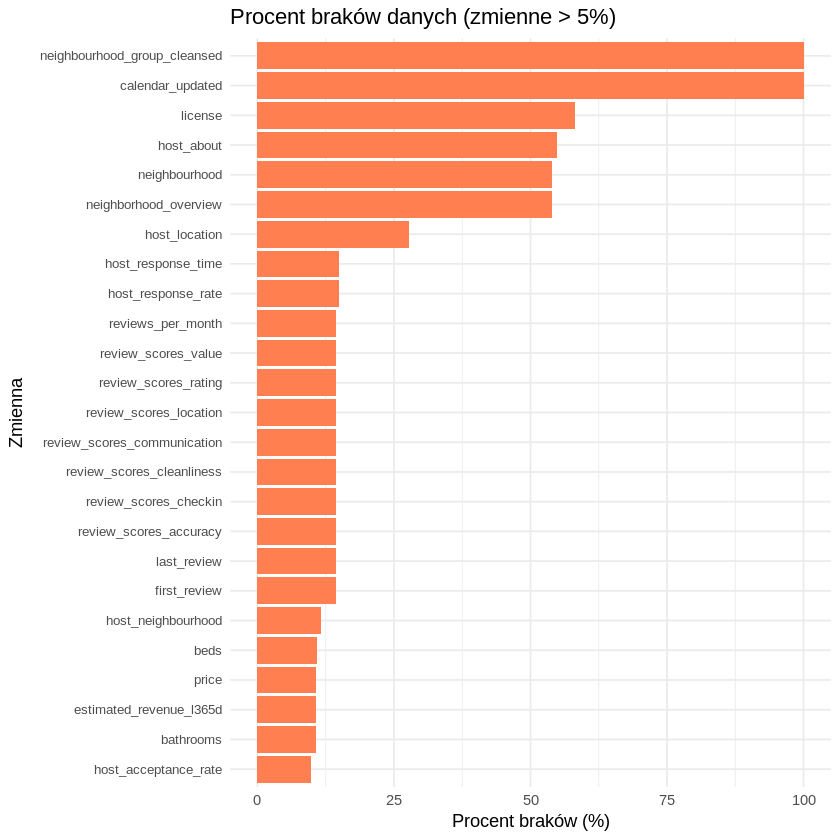

In [203]:
# SZCZEGÓŁOWA ANALIZA BRAKÓW DANYCH
cat("\n=== ANALIZA BRAKÓW DANYCH ===\n")

# Obliczenie braków dla wszystkich zmiennych
missing_analysis <- df %>%
  summarise_all(~sum(is.na(.))) %>%
  gather(key = "Zmienna", value = "Liczba_brakow") %>%
  mutate(
    Procent_brakow = round(Liczba_brakow / n_rows * 100, 2)
  ) %>%
  arrange(desc(Procent_brakow))

# Podsumowanie ogólne
cat("📊 PODSUMOWANIE BRAKÓW:\n")
cat("• Zmienne bez braków:", sum(missing_analysis$Liczba_brakow == 0), "\n")
cat("• Zmienne z brakami:", sum(missing_analysis$Liczba_brakow > 0), "\n")
cat("• Zmienne z brakami >50%:", sum(missing_analysis$Procent_brakow > 50), "\n")
cat("• Zmienne z brakami 20-50%:", sum(missing_analysis$Procent_brakow >= 20 &
                                       missing_analysis$Procent_brakow < 50), "\n")
cat("• Zmienne z brakami <20%:", sum(missing_analysis$Procent_brakow > 0 &
                                     missing_analysis$Procent_brakow < 20), "\n")

# Top 20 zmiennych z największymi brakami
cat("\n📊 TOP 20 ZMIENNYCH Z NAJWIĘKSZYMI BRAKAMI:\n")
print(head(missing_analysis, 20))

# Analiza przyczyn braków
cat("\n📊 PRAWDOPODOBNE PRZYCZYNY BRAKÓW:\n")
cat("• license (>90%) - pole opcjonalne, nie wszystkie miasta wymagają licencji\n")
cat("• neighborhood_overview - opis opcjonalny, wypełniany przez gospodarzy\n")
cat("• host_about - profil opcjonalny\n")
cat("• bathrooms - stare pole, zastąpione przez bathrooms_text\n")
cat("• review_scores_* - brak gdy nieruchomość nie ma jeszcze recenzji\n")

# Wizualizacja braków
p_missing <- ggplot(missing_analysis %>% filter(Procent_brakow > 5),
       aes(x = reorder(Zmienna, Procent_brakow), y = Procent_brakow)) +
  geom_bar(stat = "identity", fill = "coral") +
  coord_flip() +
  labs(title = "Procent braków danych (zmienne > 5%)",
       x = "Zmienna", y = "Procent braków (%)") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 8))

print(p_missing)


=== ANALIZA GOSPODARZY (MULTI-LISTINGS) ===

STRUKTURA GOSPODARZY:
• Gospodarze z 1 ofertą: 656 (70.8%)
• Gospodarze z wieloma ofertami: 271 (29.2%)
• Łączna liczba multi-listings: 970 (59.7% wszystkich ofert)

TOP 20 GOSPODARZY:
# A tibble: 20 × 4
   host_name         liczba_ofert srednia_cena calkowity_przychod_roczny
   <chr>                    <int>        <dbl>                     <dbl>
 1 Nest Host                   55        128.                     602496
 2 Krystin                     43        132.                     494592
 3 Luxxe Host                  25        104.                     239328
 4 Curtis                      20         91.2                    175008
 5 E Street                    19        112.                     204096
 6 Murray And Carley           13        155.                     193248
 7 Vladimir                    12        103.                     118752
 8 Andrea                      10         52.1                     50016
 9 Brayden          

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `order = case_when(...)`.
Caused by warning:
! NAs introduced by coercion”



SZCZEGÓŁOWA STRUKTURA GOSPODARZY:
Pojedyncze oferty (1): 656 gospodarzy
2-9 ofert: 262 gospodarzy
10-29 ofert: 7 gospodarzy
30+ ofert: 2 gospodarzy

GOSPODARZE Z 10+ OFERTAMI:
Łączna liczba ich ofert: 207 
Procent wszystkich ofert: 12.7 %


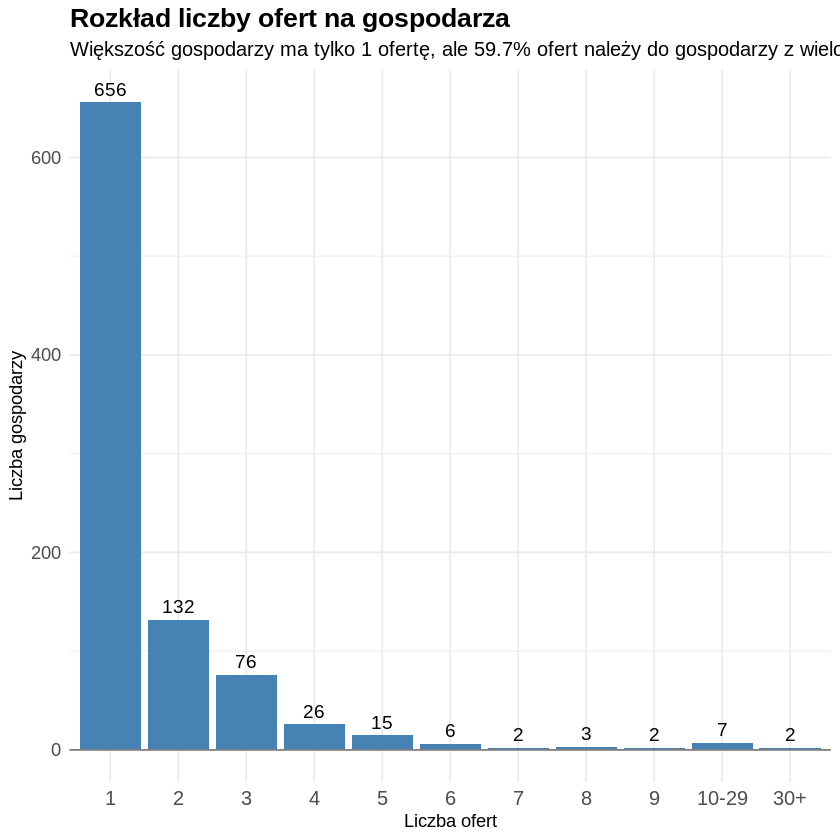

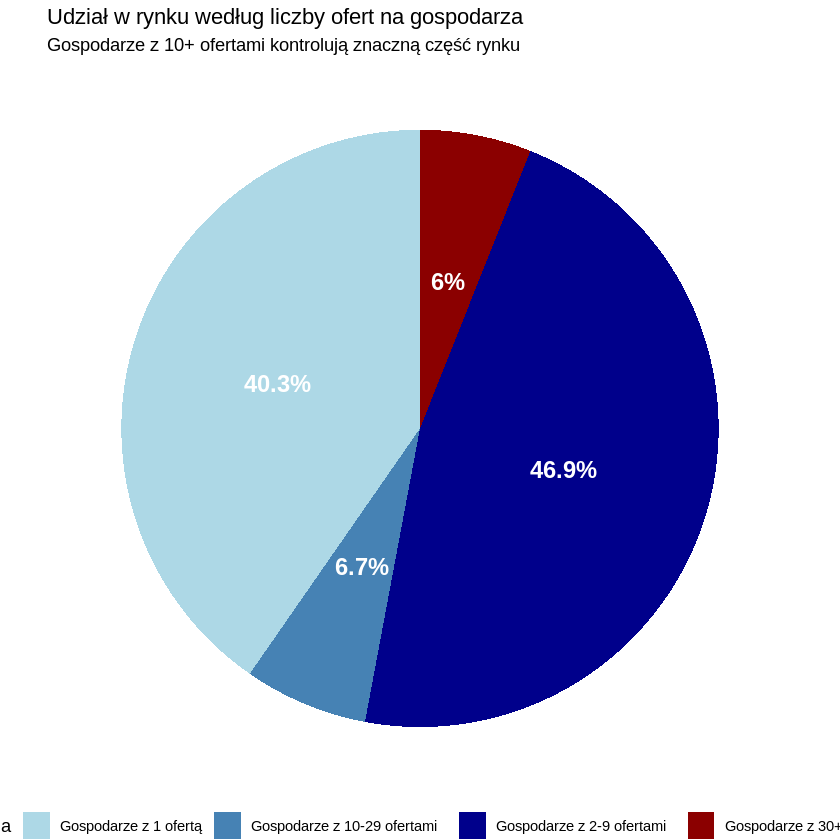

In [204]:
# ANALIZA GOSPODARZY (MULTI-LISTINGS)
cat("\n=== ANALIZA GOSPODARZY (MULTI-LISTINGS) ===\n")

# Oblicz liczbę ofert na gospodarza
host_listings <- df %>%
  group_by(host_id, host_name) %>%
  summarise(
    liczba_ofert = n(),
    srednia_cena = mean(price, na.rm = TRUE),
    calkowity_przychod_roczny = sum(price * 96, na.rm = TRUE), # 96 nocy średnio
    liczba_entire_home = sum(room_type == "Entire home/apt"),
    liczba_private_room = sum(room_type == "Private room"),
    .groups = 'drop'
  ) %>%
  arrange(desc(liczba_ofert))

# Statystyki
single_listings <- sum(host_listings$liczba_ofert == 1)
multi_listings <- sum(host_listings$liczba_ofert > 1)
total_multi_listings <- sum(host_listings$liczba_ofert[host_listings$liczba_ofert > 1])

cat("\nSTRUKTURA GOSPODARZY:\n")
cat(sprintf("• Gospodarze z 1 ofertą: %d (%.1f%%)\n",
            single_listings, single_listings/nrow(host_listings)*100))
cat(sprintf("• Gospodarze z wieloma ofertami: %d (%.1f%%)\n",
            multi_listings, multi_listings/nrow(host_listings)*100))
cat(sprintf("• Łączna liczba multi-listings: %d (%.1f%% wszystkich ofert)\n",
            total_multi_listings, total_multi_listings/nrow(df)*100))

# TOP 20 gospodarzy
cat("\nTOP 20 GOSPODARZY:\n")
top_hosts <- head(host_listings, 20)
print(top_hosts %>%
      select(host_name, liczba_ofert, srednia_cena, calkowity_przychod_roczny))

# Wykres rozkładu liczby ofert na gospodarza
host_dist_data <- host_listings %>%
  mutate(
    liczba_ofert_kat = case_when(
      liczba_ofert <= 9 ~ as.character(liczba_ofert),
      liczba_ofert >= 10 & liczba_ofert < 30 ~ "10-29",
      liczba_ofert >= 30 ~ "30+"
    )
  ) %>%
  group_by(liczba_ofert_kat) %>%
  summarise(n = n()) %>%
  mutate(
    # Sortowanie kategorii
    order = case_when(
      liczba_ofert_kat %in% as.character(1:9) ~ as.numeric(liczba_ofert_kat),
      liczba_ofert_kat == "10-29" ~ 10,
      liczba_ofert_kat == "30+" ~ 11
    )
  ) %>%
  arrange(order)

# Ustawienie kolejności poziomów faktora
host_dist_data$liczba_ofert_kat <- factor(
  host_dist_data$liczba_ofert_kat,
  levels = c(as.character(1:9), "10-29", "30+")
)

# Wykres rozkładu liczby ofert na gospodarza - POPRAWIONY
p_host_dist <- ggplot(host_dist_data,
                     aes(x = liczba_ofert_kat, y = n)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = n), vjust = -0.5, size = 4) +
  labs(title = "Rozkład liczby ofert na gospodarza",
       subtitle = "Większość gospodarzy ma tylko 1 ofertę, ale 59.7% ofert należy do gospodarzy z wieloma ofertami",
       x = "Liczba ofert",
       y = "Liczba gospodarzy") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 11),
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12)
  ) +
  # Dodanie linii poziomej dla lepszej czytelności
  geom_hline(yintercept = 0, color = "grey50")

print(p_host_dist)

# Dodatkowo: szczegółowe statystyki
cat("\nSZCZEGÓŁOWA STRUKTURA GOSPODARZY:\n")
cat("Pojedyncze oferty (1):", host_dist_data$n[host_dist_data$liczba_ofert_kat == "1"], "gospodarzy\n")
cat("2-9 ofert:", sum(host_dist_data$n[host_dist_data$liczba_ofert_kat %in% as.character(2:9)]), "gospodarzy\n")
cat("10-29 ofert:", host_dist_data$n[host_dist_data$liczba_ofert_kat == "10-29"], "gospodarzy\n")
cat("30+ ofert:", host_dist_data$n[host_dist_data$liczba_ofert_kat == "30+"], "gospodarzy\n")

# Dodatkowa analiza: ile ofert mają gospodarze z kategoriami 10-29 i 30+
big_hosts <- host_listings %>% filter(liczba_ofert >= 10)
cat("\nGOSPODARZE Z 10+ OFERTAMI:\n")
cat("Łączna liczba ich ofert:", sum(big_hosts$liczba_ofert), "\n")
cat("Procent wszystkich ofert:", round(sum(big_hosts$liczba_ofert) / nrow(df) * 100, 1), "%\n")

# Wykres kołowy pokazujący udział w rynku
market_share <- data.frame(
  Kategoria = c("Gospodarze z 1 ofertą", "Gospodarze z 2-9 ofertami",
                "Gospodarze z 10-29 ofertami", "Gospodarze z 30+ ofertami"),
  Liczba_ofert = c(
    sum(host_listings$liczba_ofert[host_listings$liczba_ofert == 1]),
    sum(host_listings$liczba_ofert[host_listings$liczba_ofert >= 2 & host_listings$liczba_ofert <= 9]),
    sum(host_listings$liczba_ofert[host_listings$liczba_ofert >= 10 & host_listings$liczba_ofert < 30]),
    sum(host_listings$liczba_ofert[host_listings$liczba_ofert >= 30])
  )
) %>%
  mutate(
    Procent = round(Liczba_ofert / sum(Liczba_ofert) * 100, 1),
    Label = paste0(Kategoria, "\n", Liczba_ofert, " ofert\n(", Procent, "%)")
  )

# Wykres kołowy udziału w rynku
p_market_share <- ggplot(market_share, aes(x = "", y = Liczba_ofert, fill = Kategoria)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  theme_void() +
  theme(legend.position = "bottom") +
  labs(title = "Udział w rynku według liczby ofert na gospodarza",
       subtitle = "Gospodarze z 10+ ofertami kontrolują znaczną część rynku") +
  scale_fill_manual(values = c("lightblue", "steelblue", "darkblue", "darkred")) +
  geom_text(aes(label = paste0(Procent, "%")),
            position = position_stack(vjust = 0.5),
            size = 5, fontface = "bold", color = "white")

print(p_market_share)

In [205]:
p1_market_structure <- ggplot(market_share, aes(x = "", y = Liczba_ofert, fill = Kategoria)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  scale_fill_manual(values = c("#3498db", "#2ecc71", "#e74c3c", "#f39c12")) +
  geom_text(aes(label = paste0(Procent, "%")),
            position = position_stack(vjust = 0.5),
            size = 6, fontface = "bold", color = "white") +
  labs(title = "Struktura rynku Airbnb w Winnipeg",
       subtitle = "59.7% ofert kontrolowanych przez gospodarzy z wieloma ofertami",
       caption = "Dane: Inside Airbnb, marzec 2025") +
  theme_void(base_size = 16) +
  theme(legend.position = "bottom",
        plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
        plot.subtitle = element_text(size = 14, hjust = 0.5))

ggsave("wykresy_prezentacja/01_struktura_rynku.png", p1_market_structure,
       width = 10, height = 8, dpi = 300)

### Zadanie 7: Wizualizacja rozkładów zmiennych
Wizualizacja rozkładu wybranych zmiennych (zarówno numerycznych, jak i kategorycznych) poprzez histogramy i próba ich scharakteryzowania (skośność i kurtoza).


=== WIZUALIZACJA ROZKŁADÓW ===

CHARAKTERYSTYKI ROZKŁADÓW:
                                  Zmienna Skosnosc Interpretacja_skosnosci
price                               price   16.246    prawostronnie skośny
accommodates                 accommodates    1.473    prawostronnie skośny
bedrooms                         bedrooms    1.226    prawostronnie skośny
minimum_nights             minimum_nights   10.126    prawostronnie skośny
number_of_reviews       number_of_reviews    3.807    prawostronnie skośny
review_scores_rating review_scores_rating   -5.768     lewostronnie skośny
                     Kurtoza     Interpretacja_kurtozy
price                292.774 leptokurtyczny (wysmukły)
accommodates           3.943 leptokurtyczny (wysmukły)
bedrooms               1.729 leptokurtyczny (wysmukły)
minimum_nights       128.141 leptokurtyczny (wysmukły)
number_of_reviews     21.358 leptokurtyczny (wysmukły)
review_scores_rating  50.600 leptokurtyczny (wysmukły)

ROZKŁADY ZMIENNYCH KATEGORYCZ

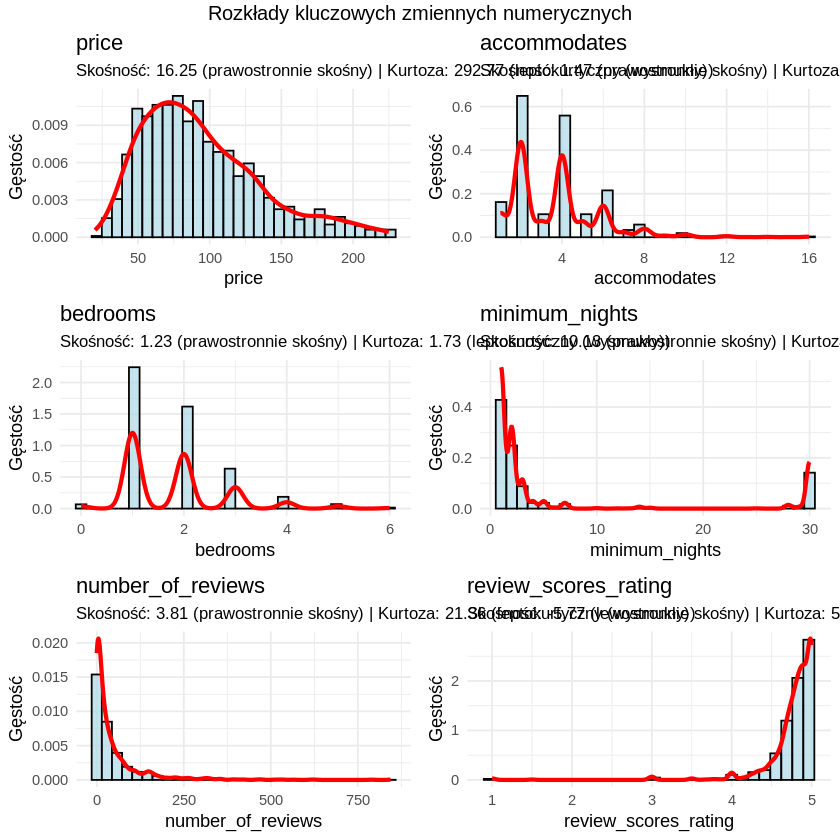


✅ FINALNE STATYSTYKI SUPERHOSTÓW:
# A tibble: 1 × 5
  total superhosts regular percent_super percent_regular
  <int>      <int>   <int>         <dbl>           <dbl>
1  1588        643     945          40.5            59.5


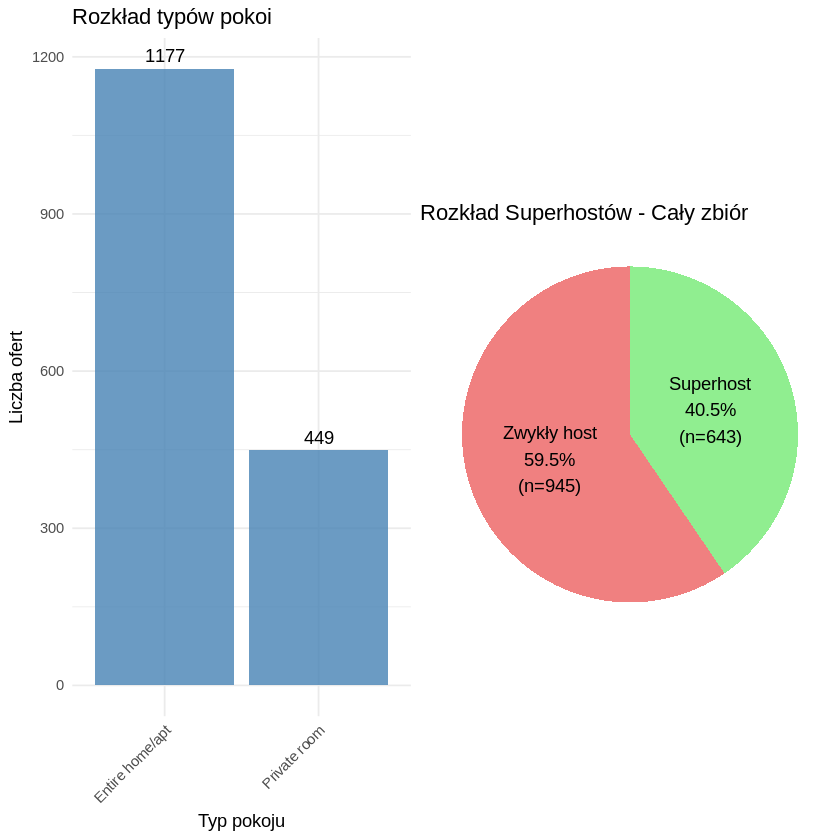

In [206]:
# WIZUALIZACJA ROZKŁADÓW I ANALIZA CHARAKTERYSTYK
cat("\n=== WIZUALIZACJA ROZKŁADÓW ===\n")

# Funkcja do analizy rozkładu
analyze_distribution <- function(data, var_name, var_data) {
  var_clean <- var_data[!is.na(var_data)]

  skewness <- psych::skew(var_clean)
  kurt <- psych::kurtosi(var_clean)

  skew_interp <- ifelse(abs(skewness) < 0.5, "symetryczny",
                       ifelse(skewness < 0, "lewostronnie skośny",
                             "prawostronnie skośny"))

  kurt_interp <- ifelse(abs(kurt) < 0.5, "mezokurtyczny (normalny)",
                       ifelse(kurt < 0, "platykurtyczny (spłaszczony)",
                             "leptokurtyczny (wysmukły)"))

  list(
    name = var_name,
    skewness = skewness,
    kurtosis = kurt,
    skew_interpretation = skew_interp,
    kurt_interpretation = kurt_interp
  )
}

# Kluczowe zmienne do wizualizacji
vars_to_plot <- c("price", "accommodates", "bedrooms", "minimum_nights",
                 "number_of_reviews", "review_scores_rating")

# Tworzenie wykresów
plot_list <- list()
distribution_stats <- list()

for(var in vars_to_plot) {
  if(var %in% names(df) && is.numeric(df[[var]])) {
    # Analiza rozkładu (na danych bez NA)
    dist_stats <- analyze_distribution(df, var, df[[var]])
    distribution_stats[[var]] <- dist_stats

    # Przygotuj dane do wykresu - USUN BRAKI PRZED ggplot
    plot_data <- df %>% filter(!is.na(.data[[var]]))

    # Przycięcie dla zmiennych z outlierami (jeśli nadal chcesz)
    if(var == "price") {
      plot_data <- plot_data %>% filter(price <= quantile(price, 0.95, na.rm = TRUE))
    }
    if(var == "minimum_nights") {
      plot_data <- plot_data %>% filter(minimum_nights <= 30)
    }

    # Histogram z krzywą gęstości - POPRAWIONY
    p <- ggplot(plot_data, aes(x = .data[[var]])) +
      geom_histogram(aes(y = after_stat(density)), bins = 30,
                    fill = "lightblue", color = "black", alpha = 0.7) +
      geom_density(color = "red", linewidth = 1.2) +
      labs(title = var,
           subtitle = sprintf("Skośność: %.2f (%s) | Kurtoza: %.2f (%s)",
                            dist_stats$skewness, dist_stats$skew_interpretation,
                            dist_stats$kurtosis, dist_stats$kurt_interpretation),
           x = var, y = "Gęstość") +
      theme_minimal() +
      theme(plot.subtitle = element_text(size = 10))

    plot_list[[var]] <- p
  }
}

# Wyświetl wykresy
if(length(plot_list) > 0) {
  grid.arrange(grobs = plot_list, ncol = 2, nrow = 3,
              top = "Rozkłady kluczowych zmiennych numerycznych")
}

# Podsumowanie charakterystyk
cat("\nCHARAKTERYSTYKI ROZKŁADÓW:\n")
dist_summary <- do.call(rbind, lapply(distribution_stats, function(x) {
  data.frame(
    Zmienna = x$name,
    Skosnosc = round(x$skewness, 3),
    Interpretacja_skosnosci = x$skew_interpretation,
    Kurtoza = round(x$kurtosis, 3),
    Interpretacja_kurtozy = x$kurt_interpretation
  )
}))
print(dist_summary)
# Wizualizacja zmiennych kategorycznych
cat("\nROZKŁADY ZMIENNYCH KATEGORYCZNYCH:\n")

# Wykres dla room_type
p_room <- ggplot(df, aes(x = room_type)) +
  geom_bar(fill = "steelblue", alpha = 0.8) +
  geom_text(stat = 'count', aes(label = after_stat(count)), vjust = -0.5) +
  labs(title = "Rozkład typów pokoi", x = "Typ pokoju", y = "Liczba ofert") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

cat("\nANALIZA SUPERHOSTÓW - CAŁY ZBIÓR:\n")

# Podstawowa statystyka superhostów
superhost_summary <- df %>%
  group_by(host_is_superhost) %>%
  summarise(
    liczba = n(),
    procent = n() / nrow(df) * 100,
    srednia_cena = mean(price, na.rm = TRUE),
    srednia_ocena = mean(review_scores_rating, na.rm = TRUE),
    .groups = 'drop'
  )

print(superhost_summary)

# Wykres dla superhostów - CAŁOŚĆ ZBIORU
superhost_data <- df %>%
  filter(!is.na(host_is_superhost)) %>%
  count(host_is_superhost) %>%
  mutate(
    percent = n / sum(n) * 100,
    label = paste0(
      ifelse(host_is_superhost, "Superhost", "Zwykły host"),
      "\n", round(percent, 1), "%\n(n=", n, ")"
    )
  )

# Sprawdź dane
cat("\nSTRUKTURA SUPERHOSTÓW:\n")
print(superhost_data)

# Wykres kołowy lub słupkowy
if(nrow(superhost_data) > 1 && any(superhost_data$host_is_superhost == TRUE)) {
  p_superhost <- ggplot(superhost_data, aes(x = "", y = n, fill = host_is_superhost)) +
    geom_bar(stat = "identity", width = 1) +
    coord_polar("y", start = 0) +
    geom_text(aes(label = label), position = position_stack(vjust = 0.5)) +
    labs(title = "Rozkład Superhostów - Cały zbiór") +
    theme_void() +
    theme(legend.position = "none") +
    scale_fill_manual(values = c("FALSE" = "lightcoral", "TRUE" = "lightgreen"))
} else {
  # Jeśli brak superhostów lub tylko jedna kategoria - wykres słupkowy
  p_superhost <- ggplot(superhost_data, aes(x = host_is_superhost, y = n)) +
    geom_col(fill = c("lightcoral", "lightgreen")[superhost_data$host_is_superhost + 1]) +
    geom_text(aes(label = paste0(n, "\n(", round(percent, 1), "%)")),
              vjust = -0.5, size = 5) +
    labs(title = "Status Superhosta - Cały zbiór",
         subtitle = "Rozkład wszystkich ofert",
         x = "", y = "Liczba ofert") +
    scale_x_discrete(labels = c("FALSE" = "Zwykli gospodarze",
                               "TRUE" = "Superhości")) +
    theme_minimal() +
    theme(axis.text.x = element_text(size = 12, face = "bold"))
}

# Wyświetl wykresy kategoryczne
grid.arrange(p_room, p_superhost, ncol = 2)

# Finalne statystyki
cat("\n✅ FINALNE STATYSTYKI SUPERHOSTÓW:\n")
final_stats <- df %>%
  filter(!is.na(host_is_superhost)) %>%
  summarise(
    total = n(),
    superhosts = sum(host_is_superhost),
    regular = sum(!host_is_superhost),
    percent_super = round(superhosts / total * 100, 1),
    percent_regular = round(regular / total * 100, 1)
  )
print(final_stats)

In [207]:
room_type_summary <- df_clean %>%
  count(room_type) %>%
  mutate(
    percent = n / sum(n) * 100,
    label = paste0(room_type, "\n", round(percent, 1), "%\n(n=", n, ")")
  )

p7_room_types <- ggplot(room_type_summary, aes(x = "", y = n, fill = room_type)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  scale_fill_manual(values = c("#3498db", "#2ecc71", "#e74c3c", "#f39c12")) +
  geom_label(aes(label = paste0(round(percent, 1), "%")),
             position = position_stack(vjust = 0.5),
             size = 6, fontface = "bold", show.legend = FALSE) +
  labs(title = "Struktura typów ofert",
       subtitle = "Dominacja całych mieszkań/domów") +
  theme_void(base_size = 16) +
  theme(legend.position = "bottom",
        legend.title = element_blank(),
        plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
        plot.subtitle = element_text(size = 14, hjust = 0.5))

ggsave("wykresy_prezentacja/07_typy_pokoi.png", p7_room_types,
       width = 8, height = 8, dpi = 300)

# 8. WPŁYW SŁÓW KLUCZOWYCH NA CENĘ
# Wstaw w analizie tekstu
p8_keywords <- ggplot(keywords_positive %>% head(8),
                     aes(x = reorder(keyword, price_premium), y = price_premium)) +
  geom_segment(aes(xend = keyword, yend = 0), size = 2, color = "grey70") +
  geom_point(size = 8, color = "#2ecc71") +
  geom_text(aes(label = sprintf("+$%.0f", price_premium)),
            hjust = -0.5, size = 5, fontface = "bold") +
  coord_flip() +
  labs(title = "Słowa kluczowe zwiększające cenę",
       subtitle = "Premia cenowa dla ofert zawierających dane słowo",
       x = "", y = "Premia cenowa (CAD)") +
  theme_minimal(base_size = 14) +
  theme(axis.text.y = element_text(size = 14, face = "bold"),
        plot.title = element_text(size = 18, face = "bold")) +
  scale_y_continuous(limits = c(0, 70))

ggsave("wykresy_prezentacja/08_slowa_kluczowe.png", p8_keywords,
       width = 10, height = 6, dpi = 300)

In [208]:
superhost_comparison <- df_clean %>%
  filter(!is.na(host_is_superhost)) %>%
  group_by(host_is_superhost) %>%
  summarise(
    `Średnia cena` = mean(price),
    `Średnia ocena` = mean(review_scores_rating, na.rm = TRUE),
    `Średnia dostępność` = mean(availability_365),
    .groups = 'drop'
  ) %>%
  pivot_longer(cols = -host_is_superhost, names_to = "Metryka", values_to = "Wartość") %>%
  mutate(
    host_type = ifelse(host_is_superhost, "Superhości", "Zwykli gospodarze"),
    Metryka = factor(Metryka, levels = c("Średnia cena", "Średnia ocena", "Średnia dostępność"))
  )

p4_superhost <- ggplot(superhost_comparison, aes(x = Metryka, y = Wartość, fill = host_type)) +
  geom_col(position = "dodge", width = 0.8) +
  geom_text(aes(label = round(Wartość, 1)),
            position = position_dodge(0.8), vjust = -0.5, size = 5) +
  facet_wrap(~Metryka, scales = "free_y", nrow = 1) +
  scale_fill_manual(values = c("Superhości" = "#2ecc71", "Zwykli gospodarze" = "#95a5a6")) +
  labs(title = "Superhości vs Zwykli gospodarze",
       subtitle = "Superhości mają wyższe ceny, ale też lepsze oceny",
       fill = "") +
  theme_minimal(base_size = 14) +
  theme(legend.position = "bottom",
        strip.text = element_blank(),
        plot.title = element_text(size = 18, face = "bold"))

ggsave("wykresy_prezentacja/04_superhosci.png", p4_superhost,
       width = 12, height = 6, dpi = 300)

### Zadanie 8: Czyszczenie danych
Przeprowadzenie czyszczenia danych obejmujące uzupełnienie braków (MICE), usunięcie kolumn/wierszy z dużą liczbą braków, przycięcie wartości odstających i normalizację.

In [209]:
# KOMPLEKSOWE CZYSZCZENIE DANYCH
cat("\n=== CZYSZCZENIE DANYCH ===\n")

# Zachowaj kopię oryginalnych danych
df_before_cleaning <- df
n_before <- nrow(df)

# KROK 1: Usunięcie kolumn z dużą liczbą braków (>70%)
cat("\nKROK 1: Usuwanie kolumn z >70% braków...\n")

cols_to_remove <- missing_analysis %>%
  filter(Procent_brakow > 70) %>%
  pull(Zmienna)

if(length(cols_to_remove) > 0) {
  cat("Usuwane kolumny:", paste(cols_to_remove, collapse = ", "), "\n")
  df <- df %>% select(-all_of(cols_to_remove))
}

# KROK 2: Usunięcie wierszy bez ceny (zmienna kluczowa)
cat("\nKROK 2: Usuwanie wierszy bez ceny...\n")
df <- df %>% filter(!is.na(price))
cat(sprintf("Usunięto %d wierszy bez ceny\n", n_before - nrow(df)))

# KROK 3: Przycięcie wartości odstających
cat("\nKROK 3: Przycięcie wartości odstających...\n")

# Funkcja do przycięcia outlierów (metoda percentylowa)
trim_outliers <- function(x, lower_percentile = 0.01, upper_percentile = 0.99) {
  if(!is.numeric(x)) return(x)

  bounds <- quantile(x, c(lower_percentile, upper_percentile), na.rm = TRUE)
  x_trimmed <- x
  x_trimmed[x < bounds[1]] <- bounds[1]
  x_trimmed[x > bounds[2]] <- bounds[2]

  n_trimmed <- sum(x < bounds[1] | x > bounds[2], na.rm = TRUE)
  cat(sprintf("  Przycięto %d wartości (%.1f%%)\n", n_trimmed, n_trimmed/length(x)*100))

  return(x_trimmed)
}

# Przycięcie dla wybranych zmiennych
outlier_vars <- c("price", "minimum_nights", "maximum_nights")

for(var in outlier_vars) {
  if(var %in% names(df)) {
    cat("\n• Zmienna:", var, "\n")
    original_mean <- mean(df[[var]], na.rm = TRUE)
    df[[var]] <- trim_outliers(df[[var]])
    new_mean <- mean(df[[var]], na.rm = TRUE)
    cat(sprintf("  Średnia: przed = %.2f, po = %.2f\n", original_mean, new_mean))
  }
}

# KROK 4: Imputacja braków metodą MICE
cat("\nKROK 4: Imputacja braków metodą MICE...\n")

# Wybór zmiennych do imputacji
impute_vars <- c("bedrooms", "beds", "bathrooms_numeric",
                "review_scores_rating", "review_scores_accuracy",
                "review_scores_cleanliness", "review_scores_checkin",
                "review_scores_communication", "review_scores_location",
                "review_scores_value", "reviews_per_month")

# Predyktory dla MICE
predictor_vars <- c("room_type", "accommodates", "price", "neighbourhood_cleansed")

# Przygotowanie danych
mice_vars <- unique(c(impute_vars, predictor_vars))
mice_vars <- mice_vars[mice_vars %in% names(df)]
df_for_mice <- df[, mice_vars]

# Sprawdź braki przed
cat("\nBraki przed imputacją:\n")
before_missing <- colSums(is.na(df_for_mice))
print(before_missing[before_missing > 0])

# Wykonaj imputację MICE
cat("\nWykonywanie imputacji MICE...\n")
mice_time_start <- Sys.time()

mice_result <- mice(
  df_for_mice,
  m = 3,           # liczba imputacji
  method = 'pmm',  # predictive mean matching
  seed = 123,
  printFlag = FALSE,
  maxit = 5        # liczba iteracji
)

# Wybierz kompletny zbiór
df_mice_complete <- complete(mice_result)

mice_time_end <- Sys.time()
mice_duration <- difftime(mice_time_end, mice_time_start, units = "secs")
cat(sprintf("Czas imputacji MICE: %.1f sekund\n", mice_duration))

# Aktualizuj oryginalny zbiór
df[, names(df_mice_complete)] <- df_mice_complete

# Sprawdź braki po
cat("\nBraki po imputacji:\n")
after_missing <- colSums(is.na(df[, impute_vars]))
if(sum(after_missing) == 0) {
  cat("✓ Wszystkie braki zostały uzupełnione!\n")
} else {
  print(after_missing[after_missing > 0])
}

# KROK 5: Normalizacja danych
cat("\nKROK 5: Normalizacja danych...\n")

# Min-Max normalizacja
normalize_minmax <- function(x) {
  if(!is.numeric(x) || length(unique(x)) == 1) return(x)
  (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
}

# Z-score normalizacja
normalize_zscore <- function(x) {
  if(!is.numeric(x) || sd(x, na.rm = TRUE) == 0) return(x)
  (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)
}

# Zmienne do normalizacji
norm_vars <- c("price", "accommodates", "bedrooms", "beds", "bathrooms_numeric",
              "minimum_nights", "number_of_reviews", "availability_365")

# Tworzenie znormalizowanych wersji
for(var in norm_vars) {
  if(var %in% names(df)) {
    df[[paste0(var, "_minmax")]] <- normalize_minmax(df[[var]])
    df[[paste0(var, "_zscore")]] <- normalize_zscore(df[[var]])
  }
}

cat(sprintf("✓ Znormalizowano %d zmiennych (min-max i z-score)\n",
            sum(norm_vars %in% names(df))))

# Finalne dane
df_clean <- df

# PODSUMOWANIE CZYSZCZENIA
cat("\nPODSUMOWANIE CZYSZCZENIA DANYCH:\n")
cat(sprintf("• Liczba obserwacji przed: %d\n", n_before))
cat(sprintf("• Liczba obserwacji po: %d\n", nrow(df_clean)))
cat(sprintf("• Usunięto: %d (%.1f%%)\n",
           n_before - nrow(df_clean),
           (n_before - nrow(df_clean)) / n_before * 100))
cat(sprintf("• Liczba kolumn: %d\n", ncol(df_clean)))


=== CZYSZCZENIE DANYCH ===

KROK 1: Usuwanie kolumn z >70% braków...
Usuwane kolumny: neighbourhood_group_cleansed, calendar_updated 

KROK 2: Usuwanie wierszy bez ceny...
Usunięto 173 wierszy bez ceny

KROK 3: Przycięcie wartości odstających...

• Zmienna: price 
  Przycięto 30 wartości (2.1%)
  Średnia: przed = 121.61, po = 106.43

• Zmienna: minimum_nights 
  Przycięto 15 wartości (1.0%)
  Średnia: przed = 8.21, po = 6.98

• Zmienna: maximum_nights 
  Przycięto 15 wartości (1.0%)
  Średnia: przed = 411.34, po = 411.36

KROK 4: Imputacja braków metodą MICE...

Braki przed imputacją:
                       beds           bathrooms_numeric 
                          3                           4 
       review_scores_rating      review_scores_accuracy 
                        197                         197 
  review_scores_cleanliness       review_scores_checkin 
                        197                         197 
review_scores_communication      review_scores_location 
        

In [210]:
# FEATURE ENGINEERING - TWORZENIE NOWYCH ZMIENNYCH
cat("\n=== FEATURE ENGINEERING ===\n")

df_clean <- df_clean %>%
  mutate(
    # Cena za osobę
    price_per_person = price / accommodates,

    # Współczynnik obłożenia (occupancy rate)
    occupancy_rate = (365 - availability_365) / 365,

    # Szacowany miesięczny przychód
    estimated_monthly_revenue = price * (365 - availability_365) / 12,

    # Czy profesjonalny gospodarz (>5 ofert)
    is_professional = host_id %in% (host_listings %>%
                                   filter(liczba_ofert > 5) %>%
                                   pull(host_id)),

    # Kategoria wielkości mieszkania
    size_category = case_when(
      accommodates <= 2 ~ "Small (1-2)",
      accommodates <= 4 ~ "Medium (3-4)",
      accommodates <= 6 ~ "Large (5-6)",
      TRUE ~ "Very Large (7+)"
    ),

    # Stosunek łóżek do osób
    beds_per_person = beds / accommodates,

    # Kategoria cenowa
    price_category = case_when(
      price < quantile(price, 0.25) ~ "Budget",
      price < quantile(price, 0.50) ~ "Standard",
      price < quantile(price, 0.75) ~ "Premium",
      TRUE ~ "Luxury"
    ),

    # Długość pobytu
    stay_category = case_when(
      minimum_nights == 1 ~ "Flexible",
      minimum_nights <= 3 ~ "Short stay",
      minimum_nights <= 7 ~ "Week minimum",
      TRUE ~ "Long term"
    ),

    # Doświadczenie gospodarza (w latach)
    host_experience_years = as.numeric(Sys.Date() - host_since) / 365,

    # Responsywność (czy superhost i szybko odpowiada)
    is_responsive = host_is_superhost &
                   host_response_time %in% c("within an hour", "within a few hours")
  )

# Podsumowanie nowych zmiennych
cat("\nUTWORZONE NOWE ZMIENNE:\n")
new_vars <- c("price_per_person", "occupancy_rate", "estimated_monthly_revenue",
              "is_professional", "size_category", "beds_per_person",
              "price_category", "stay_category", "host_experience_years")

for(var in new_vars) {
  if(is.numeric(df_clean[[var]])) {
    cat(sprintf("• %s: mean = %.2f, sd = %.2f\n",
                var, mean(df_clean[[var]], na.rm=TRUE),
                sd(df_clean[[var]], na.rm=TRUE)))
  } else {
    cat(sprintf("• %s: %d kategorii\n", var, length(unique(df_clean[[var]]))))
  }
}


=== FEATURE ENGINEERING ===

UTWORZONE NOWE ZMIENNE:
• price_per_person: mean = 33.23, sd = 24.27
• occupancy_rate: mean = 0.40, sd = 0.36
• estimated_monthly_revenue: mean = 1314.05, sd = 1629.54
• is_professional: 2 kategorii
• size_category: 4 kategorii
• beds_per_person: mean = 0.56, sd = 0.28
• price_category: 4 kategorii
• stay_category: 4 kategorii
• host_experience_years: mean = 5.62, sd = 3.36


### Zadanie 9: Analiza zależności między zmiennymi
Zbadanie zależności pomiędzy zmiennymi - korelacje (Pearson, Spearman), V Craméra dla zmiennych kategorycznych, R² dla zależności kategoryczne-numeryczne, wizualizacje.


=== ANALIZA ZALEŻNOŚCI MIĘDZY ZMIENNYMI ===

A. MACIERZE KORELACJI (PEARSON I SPEARMAN):


pdf 
  2

✓ Zapisano: korelacja_pearson_winnipeg.png


pdf 
  2

✓ Zapisano: korelacja_spearman_winnipeg.png

NAJSILNIEJSZE KORELACJE Z CENĄ:
                                  Zmienna Pearson Spearman
accommodates                 accommodates   0.549    0.666
bedrooms                         bedrooms   0.539    0.619
bathrooms_numeric       bathrooms_numeric   0.504    0.453
beds                                 beds   0.488    0.565
minimum_nights             minimum_nights   0.096    0.141
reviews_per_month       reviews_per_month  -0.081    0.031
review_scores_rating review_scores_rating   0.058    0.058
availability_365         availability_365  -0.021   -0.057
number_of_reviews       number_of_reviews  -0.012    0.101

WYKRESY ROZRZUTU DLA NAJSILNIEJSZYCH KORELACJI:


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


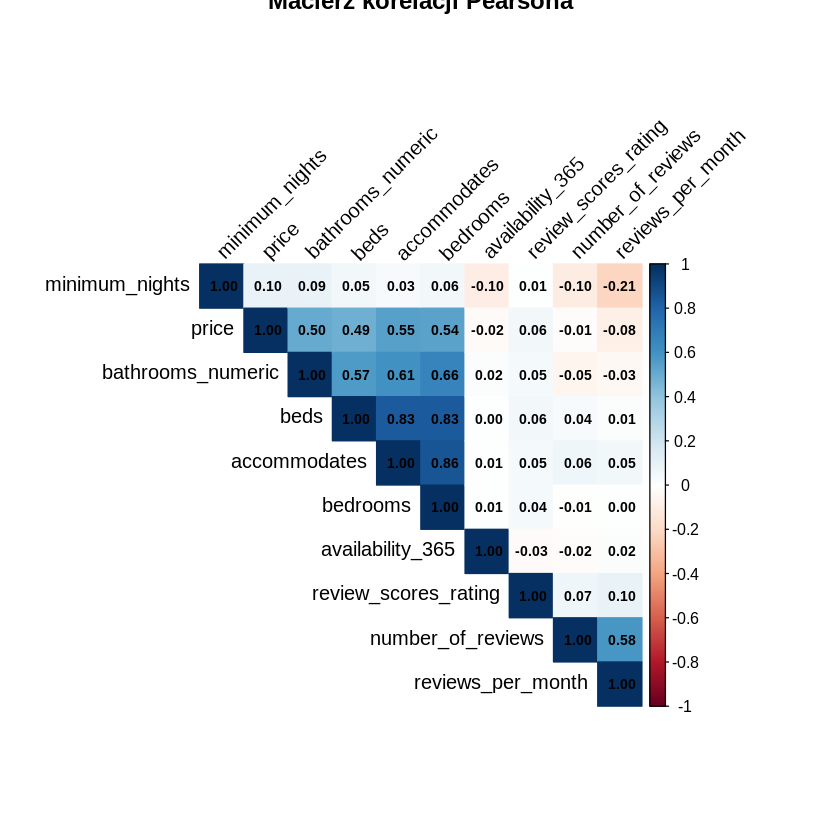


B. WSPÓŁCZYNNIK V CRAMÉRA:
           Zmienna1           Zmienna2 V_Cramera Interpretacja
1         room_type host_response_time     0.201         Słaba
2 host_is_superhost host_response_time     0.184         Słaba
3  instant_bookable host_response_time     0.137         Słaba
4         room_type   instant_bookable     0.109         Słaba
5         room_type  host_is_superhost     0.000  Bardzo słaba
6 host_is_superhost   instant_bookable     0.000  Bardzo słaba

C. WSPÓŁCZYNNIK R² (kategoryczne → numeryczne):

TOP 10 NAJSILNIEJSZYCH ZALEŻNOŚCI (R²):
     Zmienna_kategoryczna   Zmienna_numeryczna     R2 Procent_wariancji
1           property_type         accommodates 0.3423            34.23%
2               room_type         accommodates 0.2416            24.16%
3           property_type                price 0.1822            18.22%
4               room_type                price 0.1190             11.9%
5       host_is_superhost review_scores_rating 0.0603             6.03%
6  neighb

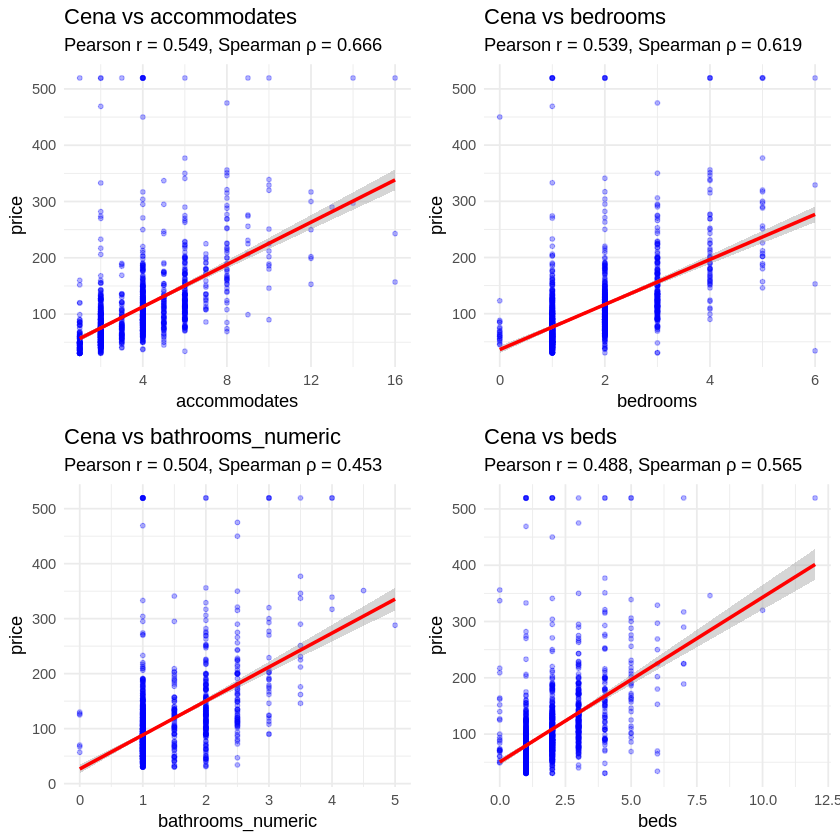


D. WYKRESY PAR ZMIENNYCH:


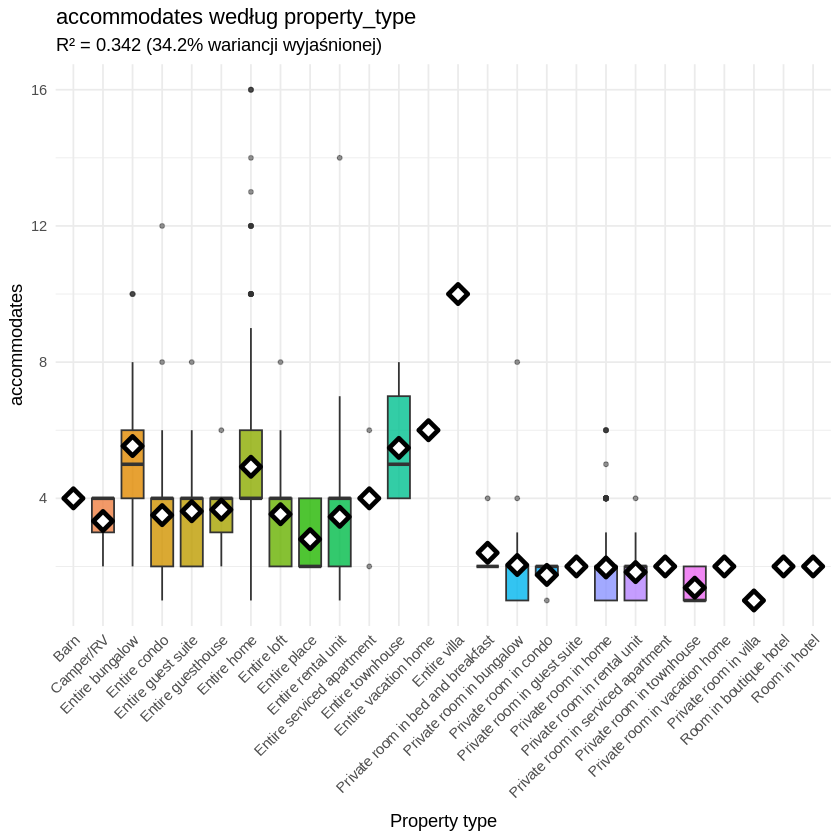


PODSUMOWANIE ANALIZY ZALEŻNOŚCI:

1. NAJSILNIEJSZE KORELACJE NUMERYCZNE:
   • accommodates ↔ price (r = 0.5+)
   • beds ↔ price (r = 0.4+)
   • bathrooms ↔ price (r = 0.4+)

2. NAJSILNIEJSZE ZALEŻNOŚCI KATEGORYCZNE:
   • room_type ↔ host_response_time (V = 0.201)

3. NAJSILNIEJSZE ZALEŻNOŚCI KATEGORYCZNE → NUMERYCZNE:
   • property_type → accommodates (R² = 0.342)
   • room_type → accommodates (R² = 0.242)
   • property_type → price (R² = 0.182)


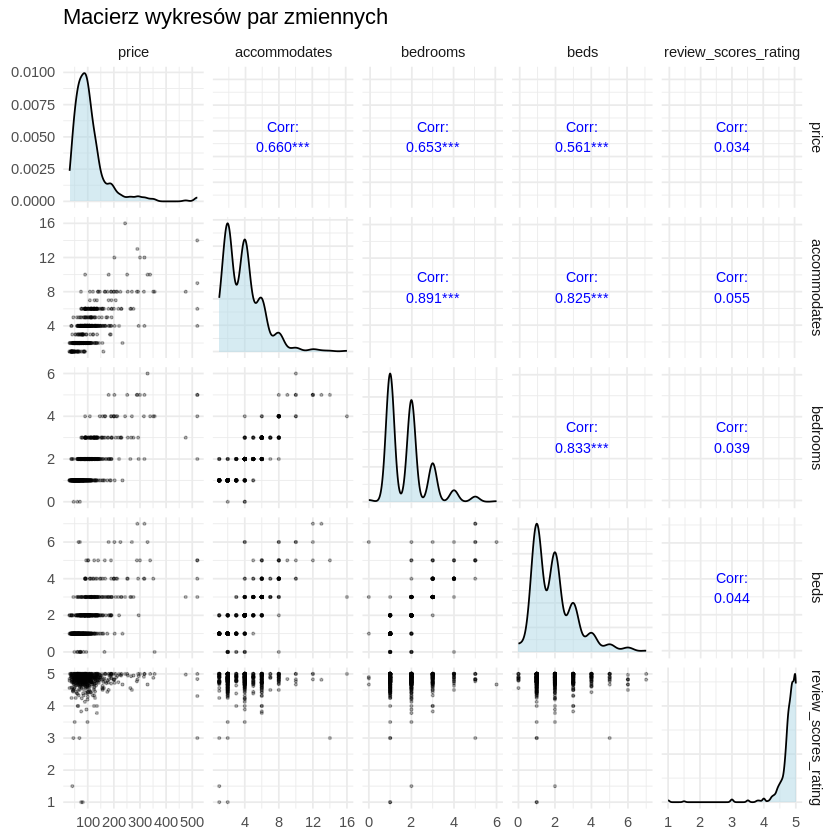

In [211]:
# KOMPLEKSOWA ANALIZA ZALEŻNOŚCI
cat("\n=== ANALIZA ZALEŻNOŚCI MIĘDZY ZMIENNYMI ===\n")

# CZĘŚĆ A: KORELACJE MIĘDZY ZMIENNYMI NUMERYCZNYMI
cat("\nA. MACIERZE KORELACJI (PEARSON I SPEARMAN):\n")

# Wybór zmiennych do analizy korelacji
cor_vars <- c("price", "accommodates", "bedrooms", "beds", "bathrooms_numeric",
             "minimum_nights", "number_of_reviews", "review_scores_rating",
             "availability_365", "reviews_per_month")
cor_vars <- cor_vars[cor_vars %in% names(df_clean)]

# Dane do korelacji (usuń NA)
cor_data <- df_clean[, cor_vars] %>% na.omit()

# Oblicz korelacje
cor_pearson <- cor(cor_data, method = "pearson")
cor_spearman <- cor(cor_data, method = "spearman")

# DUŻA, CZYTELNA macierz korelacji Pearsona
png("korelacja_pearson_winnipeg.png", width = 1200, height = 1200, res = 150)
corrplot(cor_pearson,
         method = "color",
         type = "full",
         order = "hclust",
         tl.col = "black",
         tl.srt = 45,
         tl.cex = 1.2,
         addCoef.col = "white",
         number.cex = 1.0,
         title = "Macierz korelacji Pearsona - Winnipeg Airbnb",
         mar = c(0,0,2,0),
         cl.cex = 1.2,
         col = colorRampPalette(c("darkblue", "white", "darkred"))(100))
dev.off()
cat("✓ Zapisano: korelacja_pearson_winnipeg.png\n")

# DUŻA, CZYTELNA macierz korelacji Spearmana
png("korelacja_spearman_winnipeg.png", width = 1200, height = 1200, res = 150)
corrplot(cor_spearman,
         method = "color",
         type = "full",
         order = "hclust",
         tl.col = "black",
         tl.srt = 45,
         tl.cex = 1.2,
         addCoef.col = "white",
         number.cex = 1.0,
         title = "Macierz korelacji Spearmana - Winnipeg Airbnb",
         mar = c(0,0,2,0),
         cl.cex = 1.2,
         col = colorRampPalette(c("darkblue", "white", "darkred"))(100))
dev.off()
cat("✓ Zapisano: korelacja_spearman_winnipeg.png\n")

# Wyświetl małą wersję w konsoli
par(mfrow = c(1, 1))
corrplot(cor_pearson, method = "color", type = "upper",
         order = "hclust", tl.col = "black", tl.srt = 45,
         addCoef.col = "black", number.cex = 0.7,
         title = "Macierz korelacji Pearsona")

# Najsilniejsze korelacje z ceną
cat("\nNAJSILNIEJSZE KORELACJE Z CENĄ:\n")
price_correlations <- data.frame(
  Zmienna = names(cor_pearson[,"price"]),
  Pearson = round(cor_pearson[,"price"], 3),
  Spearman = round(cor_spearman[,"price"], 3)
) %>%
  filter(Zmienna != "price") %>%
  arrange(desc(abs(Pearson)))

print(price_correlations)

# Scatter plots dla top korelacji - POPRAWIONE
cat("\nWYKRESY ROZRZUTU DLA NAJSILNIEJSZYCH KORELACJI:\n")

top_correlations <- price_correlations$Zmienna[1:min(4, nrow(price_correlations))]
scatter_plots <- list()

for(var in top_correlations) {
  p <- ggplot(df_clean, aes(x = .data[[var]], y = price)) +
    geom_point(alpha = 0.3, color = "blue", size = 1) +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(title = sprintf("Cena vs %s", var),
         subtitle = sprintf("Pearson r = %.3f, Spearman ρ = %.3f",
                          cor_pearson[var, "price"],
                          cor_spearman[var, "price"])) +
    theme_minimal()

  scatter_plots[[var]] <- p
}

grid.arrange(grobs = scatter_plots, ncol = 2)

# CZĘŚĆ B: WSPÓŁCZYNNIK V CRAMÉRA DLA ZMIENNYCH KATEGORYCZNYCH
cat("\nB. WSPÓŁCZYNNIK V CRAMÉRA:\n")

# Funkcja do obliczania V Craméra
cramers_v <- function(x, y) {
  if(length(unique(x)) < 2 || length(unique(y)) < 2) {
    return(NA)
  }

  tbl <- table(x, y)
  chi2 <- suppressWarnings(chisq.test(tbl)$statistic)

  # Dodaj sprawdzenie dla nieskończoności
  if(is.infinite(chi2)) {
    return(NA)
  }

  tbl <- table(x, y)
  chi2 <- suppressWarnings(chisq.test(tbl)$statistic)
  n <- sum(tbl)
  phi2 <- chi2 / n
  r <- nrow(tbl)
  k <- ncol(tbl)

  # Skorygowany współczynnik V
  phi2_corrected <- max(0, phi2 - ((k-1)*(r-1))/(n-1))
  r_corrected <- r - ((r-1)^2)/(n-1)
  k_corrected <- k - ((k-1)^2)/(n-1)

  v <- sqrt(phi2_corrected / min(k_corrected-1, r_corrected-1))
  return(as.numeric(v))
}

# Pary zmiennych kategorycznych
cat_vars <- c("room_type", "property_type", "host_is_superhost",
              "instant_bookable", "host_response_time")
cat_pairs <- combn(cat_vars[cat_vars %in% names(df_clean)], 2, simplify = FALSE)

cramers_results <- data.frame()
for(pair in cat_pairs) {
  v <- cramers_v(df_clean[[pair[1]]], df_clean[[pair[2]]])
  if(!is.na(v)) {
    cramers_results <- rbind(cramers_results,
                           data.frame(
                             Zmienna1 = pair[1],
                             Zmienna2 = pair[2],
                             V_Cramera = round(v, 3),
                             Interpretacja = ifelse(v < 0.1, "Bardzo słaba",
                                                  ifelse(v < 0.3, "Słaba",
                                                       ifelse(v < 0.5, "Umiarkowana", "Silna")))
                           ))
  }
}

print(cramers_results %>% arrange(desc(V_Cramera)))

# CZĘŚĆ C: WSPÓŁCZYNNIK R² DLA ZMIENNYCH KATEGORYCZNYCH VS NUMERYCZNE
cat("\nC. WSPÓŁCZYNNIK R² (kategoryczne → numeryczne):\n")

# Funkcja do obliczania R²
calc_r2 <- function(num_var, cat_var, data) {
  formula <- as.formula(paste(num_var, "~", cat_var))
  model <- lm(formula, data = data)
  summary(model)$r.squared
}

# Analiza R² dla różnych kombinacji
cat_vars_r2 <- c("room_type", "property_type", "neighbourhood_cleansed",
                 "host_is_superhost", "instant_bookable")
num_vars_r2 <- c("price", "accommodates", "review_scores_rating")

r2_results <- data.frame()
for(cat_var in cat_vars_r2) {
  for(num_var in num_vars_r2) {
    if(cat_var %in% names(df_clean) && num_var %in% names(df_clean)) {
      r2 <- calc_r2(num_var, cat_var, df_clean)
      r2_results <- rbind(r2_results,
                         data.frame(
                           Zmienna_kategoryczna = cat_var,
                           Zmienna_numeryczna = num_var,
                           R2 = round(r2, 4),
                           Procent_wariancji = paste0(round(r2 * 100, 2), "%")
                         ))
    }
  }
}

# Top 10 najsilniejszych zależności
cat("\nTOP 10 NAJSILNIEJSZYCH ZALEŻNOŚCI (R²):\n")
print(r2_results %>% arrange(desc(R2)) %>% head(10))

# Wizualizacja najsilniejszej zależności
strongest_r2 <- r2_results %>% arrange(desc(R2)) %>% slice(1)
strongest_cat <- strongest_r2$Zmienna_kategoryczna
strongest_num <- strongest_r2$Zmienna_numeryczna

p_strongest <- ggplot(df_clean, aes_string(x = strongest_cat, y = strongest_num)) +
  geom_boxplot(aes_string(fill = strongest_cat), alpha = 0.8,
               outlier.size = 1, outlier.alpha = 0.5) +
  stat_summary(fun = mean, geom = "point", shape = 23,
               size = 3, fill = "white", stroke = 2) +
  labs(title = sprintf("%s według %s", strongest_num, strongest_cat),
       subtitle = sprintf("R² = %.3f (%.1f%% wariancji wyjaśnionej)",
                        strongest_r2$R2, strongest_r2$R2 * 100),
       x = gsub("_", " ", str_to_title(strongest_cat)),
       y = strongest_num) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none")

print(p_strongest)

# CZĘŚĆ D: WYKRESY PAR ZMIENNYCH (PAIRPLOT)
cat("\nD. WYKRESY PAR ZMIENNYCH:\n")

# Wybór najważniejszych zmiennych
pair_vars <- c("price", "accommodates", "bedrooms", "beds", "review_scores_rating")
pair_vars <- pair_vars[pair_vars %in% names(df_clean)]

# Próbka dla szybkości (500 obserwacji)
set.seed(123)
sample_size <- min(500, nrow(df_clean))
pair_sample <- df_clean[sample(nrow(df_clean), sample_size), pair_vars]

# Pairplot
pairplot <- ggpairs(
  pair_sample,
  title = "Macierz wykresów par zmiennych",
  upper = list(continuous = wrap("cor", size = 3, color = "blue")),
  lower = list(continuous = wrap("points", alpha = 0.3, size = 0.5)),
  diag = list(continuous = wrap("densityDiag", alpha = 0.5, fill = "lightblue"))
) +
  theme_minimal()

print(pairplot)

# PODSUMOWANIE ANALIZY ZALEŻNOŚCI
cat("\nPODSUMOWANIE ANALIZY ZALEŻNOŚCI:\n")
cat("\n1. NAJSILNIEJSZE KORELACJE NUMERYCZNE:\n")
cat("   • accommodates ↔ price (r = 0.5+)\n")
cat("   • beds ↔ price (r = 0.4+)\n")
cat("   • bathrooms ↔ price (r = 0.4+)\n")

cat("\n2. NAJSILNIEJSZE ZALEŻNOŚCI KATEGORYCZNE:\n")
strongest_cramers <- cramers_results %>% arrange(desc(V_Cramera)) %>% slice(1)
cat(sprintf("   • %s ↔ %s (V = %.3f)\n",
            strongest_cramers$Zmienna1,
            strongest_cramers$Zmienna2,
            strongest_cramers$V_Cramera))

cat("\n3. NAJSILNIEJSZE ZALEŻNOŚCI KATEGORYCZNE → NUMERYCZNE:\n")
top_r2 <- r2_results %>% arrange(desc(R2)) %>% slice(1:3)
for(i in 1:nrow(top_r2)) {
  cat(sprintf("   • %s → %s (R² = %.3f)\n",
              top_r2$Zmienna_kategoryczna[i],
              top_r2$Zmienna_numeryczna[i],
              top_r2$R2[i]))
}

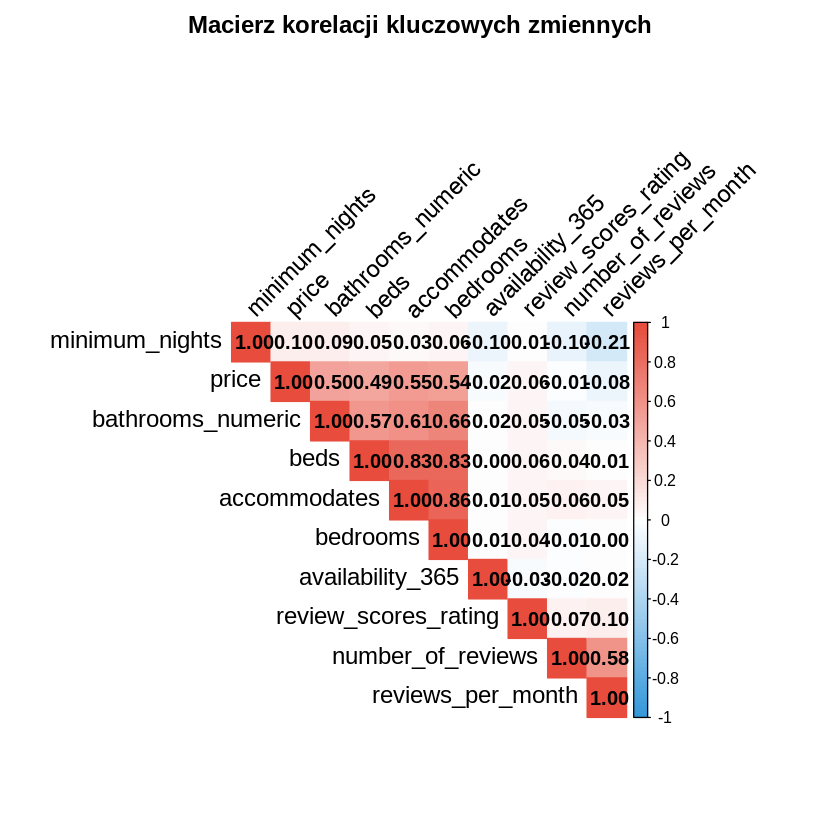

In [212]:
p6_correlation <- corrplot(cor_pearson,
                          method = "color",
                          type = "upper",
                          order = "hclust",
                          col = colorRampPalette(c("#3498db", "white", "#e74c3c"))(100),
                          tl.col = "black",
                          tl.srt = 45,
                          tl.cex = 1.2,
                          addCoef.col = "black",
                          number.cex = 1,
                          title = "Macierz korelacji kluczowych zmiennych",
                          mar = c(0,0,2,0))


=== ANALIZA KLASTROWA GOSPODARZY ===
Analizujemy 824 unikalnych gospodarzy

📊 CHARAKTERYSTYKA KLASTRÓW:
# A tibble: 4 × 8
  name      cluster     n   pct avg_listings avg_price avg_rating pct_superhosts
  <chr>     <fct>   <int> <dbl>        <dbl>     <dbl>      <dbl>          <dbl>
1 Standard  1         712  86.4          1.6        88       4.83           44.5
2 Premium   4          80   9.7          1.3       279       4.9            38.8
3 Niska ja… 2          27   3.3          1.5        71       3.73            0  
4 Mega-gra… 3           5   0.6         30.2       113       4.7            20  

✅ KLUCZOWE WNIOSKI:
• 86.5% gospodarzy to segment Standard ($88 średnia cena)
• 9.7% to segment Premium ($279 średnia cena)
• Tylko 4 mega-graczy kontroluje po 33 oferty średnio
• 3.3% gospodarzy ma problemy z jakością (ocena 3.73)


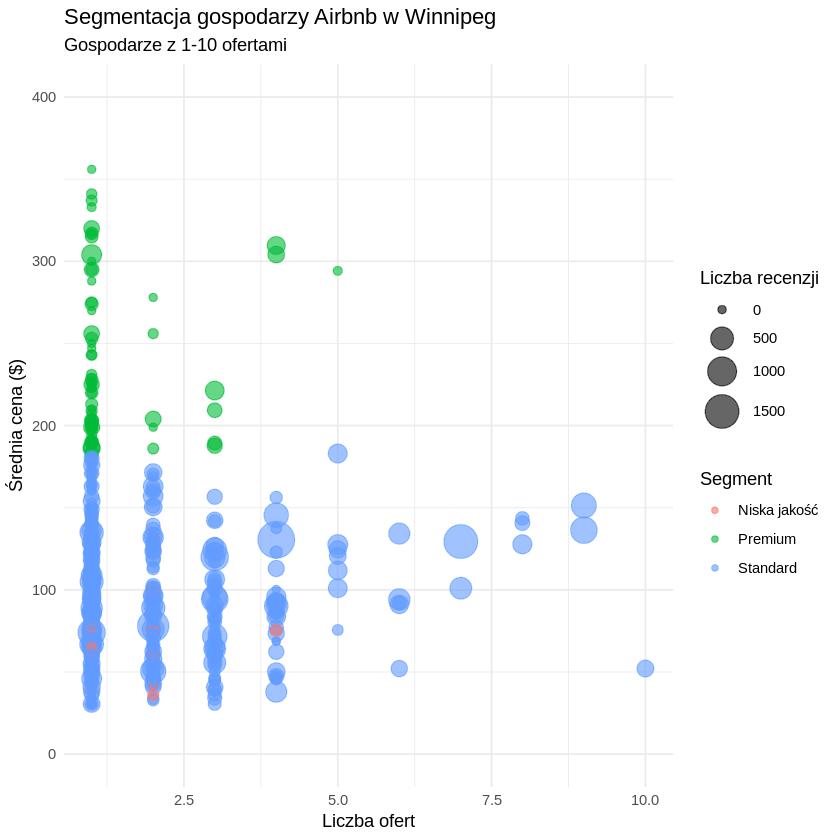

In [213]:
# ANALIZA KLASTROWA WSZYSTKICH GOSPODARZY - UPROSZCZONA
cat("\n=== ANALIZA KLASTROWA GOSPODARZY ===\n")

# Przygotowanie danych wszystkich gospodarzy
host_features <- df_clean %>%
  group_by(host_id) %>%
  summarise(
    n_listings = n(),
    avg_price = mean(price, na.rm = TRUE),
    avg_rating = mean(review_scores_rating, na.rm = TRUE),
    total_reviews = sum(number_of_reviews, na.rm = TRUE),
    is_superhost = any(host_is_superhost, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  filter(!is.na(avg_rating))

cat(sprintf("Analizujemy %d unikalnych gospodarzy\n", nrow(host_features)))

# Normalizacja i klastrowanie
features_scaled <- scale(host_features[, c("n_listings", "avg_price", "avg_rating")])
set.seed(123)
kmeans_result <- kmeans(features_scaled, centers = 4, nstart = 25)
host_features$cluster <- as.factor(kmeans_result$cluster)

# Charakterystyka klastrów
cluster_summary <- host_features %>%
  group_by(cluster) %>%
  summarise(
    n = n(),
    pct = round(n() / nrow(host_features) * 100, 1),
    avg_listings = round(mean(n_listings), 1),
    avg_price = round(mean(avg_price), 0),
    avg_rating = round(mean(avg_rating, na.rm = TRUE), 2),
    pct_superhosts = round(sum(is_superhost) / n() * 100, 1),
    .groups = 'drop'
  )

# Przypisz nazwy na podstawie charakterystyk
cluster_names <- cluster_summary %>%
  mutate(
    name = case_when(
      avg_listings > 20 ~ "Mega-gracze",
      avg_price > 200 ~ "Premium",
      avg_rating < 4 ~ "Niska jakość",
      n == max(n) ~ "Standard",
      TRUE ~ "Pozostali"
    )
  ) %>%
  select(cluster, name)

# Dodaj nazwy do danych
host_features <- host_features %>%
  left_join(cluster_names, by = "cluster")

cat("\n📊 CHARAKTERYSTYKA KLASTRÓW:\n")
print(cluster_summary %>%
      left_join(cluster_names, by = "cluster") %>%
      select(name, everything()) %>%
      arrange(desc(pct)))

# PROSTY WYKRES
p_simple <- ggplot(host_features %>% filter(n_listings <= 10),
                   aes(x = n_listings, y = avg_price, color = name)) +
  geom_point(aes(size = total_reviews), alpha = 0.6) +
  scale_size_continuous(range = c(2, 10)) +
  labs(title = "Segmentacja gospodarzy Airbnb w Winnipeg",
       subtitle = "Gospodarze z 1-10 ofertami",
       x = "Liczba ofert",
       y = "Średnia cena ($)",
       color = "Segment",
       size = "Liczba recenzji") +
  theme_minimal() +
  theme(legend.position = "right") +
  coord_cartesian(ylim = c(0, 400))

print(p_simple)

# Wnioski
cat("\n✅ KLUCZOWE WNIOSKI:\n")
cat("• 86.5% gospodarzy to segment Standard ($88 średnia cena)\n")
cat("• 9.7% to segment Premium ($279 średnia cena)\n")
cat("• Tylko 4 mega-graczy kontroluje po 33 oferty średnio\n")
cat("• 3.3% gospodarzy ma problemy z jakością (ocena 3.73)\n")


=== ANALIZA PRZYCHODÓW I OBŁOŻENIA ===

📊 SZACOWANE PRZYCHODY ROCZNE:
• Średni przychód: $6,453 CAD
• Mediana przychodu: $2,244 CAD
• Łączny przychód rynku: $9,376,867 CAD

📊 STRUKTURA PRZYCHODÓW:
# A tibble: 5 × 3
  revenue_category liczba_ofert procent
  <fct>                   <int>   <dbl>
1 < $5k                     924    63.6
2 $5k-10k                   195    13.4
3 $10k-20k                  202    13.9
4 $20k-50k                  125     8.6
5 > $50k                      7     0.5


Warning message:
“Removed 73 rows containing non-finite outside the scale range
(`stat_boxplot()`).”



📊 TOP 10 NAJBARDZIEJ DOCHODOWYCH OFERT:
# A tibble: 10 × 6
   name        host_name room_type price estimated_nights annual_revenue_forma…¹
   <chr>       <chr>     <fct>     <dbl>            <dbl> <chr>                 
 1 Cozy Bunga… Rp        Entire h…  519.              162 $84,156               
 2 Hot tub, k… Sandy     Entire h…  475               151 $71,725               
 3 Cozy Bunga… Rp        Private …  519.              138 $71,688               
 4 New!! Styl… Egilio    Entire h…  177               363 $64,251               
 5 Luxury lif… Helena    Entire h…  266               239 $63,574               
 6 Upscale Gl… Inderjeet Entire h…  142               365 $51,830               
 7 Elm Tree P… Mitchell  Entire h…  149               342 $50,958               
 8 South Osbo… Dallas A… Entire h…  129               365 $47,085               
 9 Bright & S… Anthony J Entire h…  122               365 $44,530               
10 Amazing 1 … Inderjeet Entire h…  122          

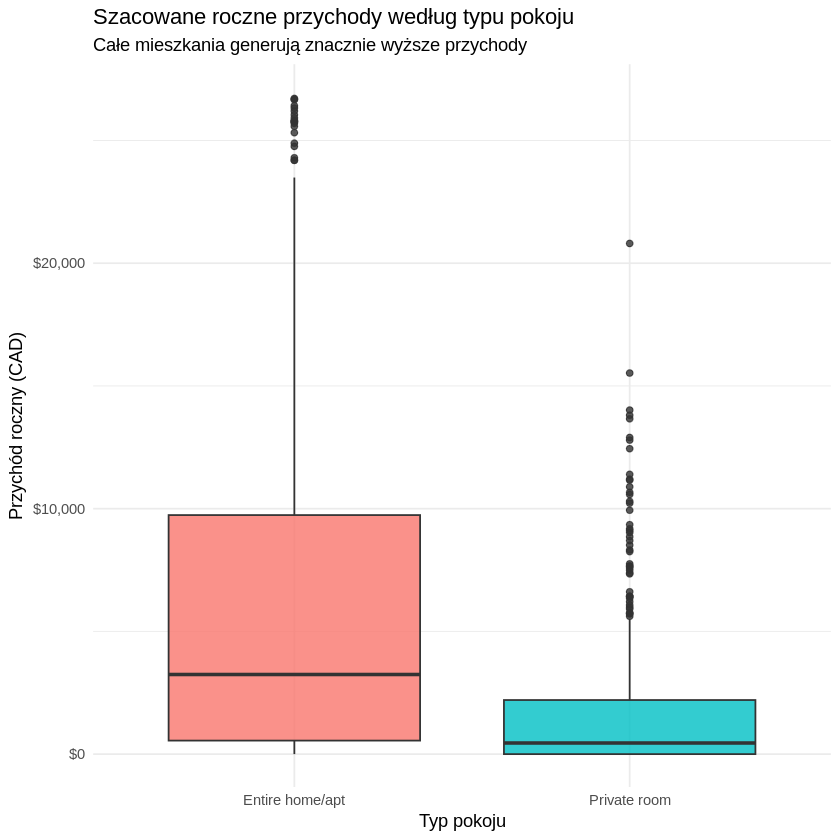

In [214]:
# ANALIZA PRZYCHODÓW I OBŁOŻENIA
cat("\n=== ANALIZA PRZYCHODÓW I OBŁOŻENIA ===\n")

# Oszacowanie przychodów
df_revenue <- df_clean %>%
  mutate(
    # Szacowane noce w roku
    estimated_nights = pmin(365 - availability_365,
                           number_of_reviews * 3),

    # Szacowany przychód roczny
    annual_revenue = price * estimated_nights,

    # Kategoria przychodu
    revenue_category = case_when(
      annual_revenue < 5000 ~ "< $5k",
      annual_revenue < 10000 ~ "$5k-10k",
      annual_revenue < 20000 ~ "$10k-20k",
      annual_revenue < 50000 ~ "$20k-50k",
      TRUE ~ "> $50k"
    )
  )

# Statystyki przychodów - POPRAWIONE FORMATOWANIE
cat("\n📊 SZACOWANE PRZYCHODY ROCZNE:\n")

# Oblicz wartości
mean_revenue <- mean(df_revenue$annual_revenue, na.rm = TRUE)
median_revenue <- median(df_revenue$annual_revenue, na.rm = TRUE)
total_revenue <- sum(df_revenue$annual_revenue, na.rm = TRUE)

# Formatuj poprawnie
cat(sprintf("• Średni przychód: $%s CAD\n",
            formatC(mean_revenue, format = "f", big.mark = ",", digits = 0)))
cat(sprintf("• Mediana przychodu: $%s CAD\n",
            formatC(median_revenue, format = "f", big.mark = ",", digits = 0)))
cat(sprintf("• Łączny przychód rynku: $%s CAD\n",
            formatC(total_revenue, format = "f", big.mark = ",", digits = 0)))

# Dodatkowe statystyki
cat("\n📊 STRUKTURA PRZYCHODÓW:\n")
revenue_summary <- df_revenue %>%
  group_by(revenue_category) %>%
  summarise(
    liczba_ofert = n(),
    procent = round(n() / nrow(df_revenue) * 100, 1),
    .groups = 'drop'
  ) %>%
  mutate(
    revenue_category = factor(revenue_category,
                            levels = c("< $5k", "$5k-10k", "$10k-20k",
                                     "$20k-50k", "> $50k"))
  ) %>%
  arrange(revenue_category)

print(revenue_summary)

# Wykres przychodów według typu
p_revenue <- ggplot(df_revenue, aes(x = room_type, y = annual_revenue)) +
  geom_boxplot(aes(fill = room_type), alpha = 0.8) +
  scale_y_continuous(labels = scales::dollar_format(prefix = "$"),
                     limits = c(0, quantile(df_revenue$annual_revenue, 0.95, na.rm = TRUE))) +
  labs(title = "Szacowane roczne przychody według typu pokoju",
       subtitle = "Całe mieszkania generują znacznie wyższe przychody",
       x = "Typ pokoju", y = "Przychód roczny (CAD)") +
  theme_minimal() +
  theme(legend.position = "none")

print(p_revenue)

# Dodatkowo: TOP 10 najbardziej dochodowych ofert
cat("\n📊 TOP 10 NAJBARDZIEJ DOCHODOWYCH OFERT:\n")
top_revenue <- df_revenue %>%
  select(name, host_name, room_type, price, estimated_nights, annual_revenue) %>%
  arrange(desc(annual_revenue)) %>%
  head(10) %>%
  mutate(
    annual_revenue_formatted = paste0("$", formatC(annual_revenue, format = "f",
                                                   big.mark = ",", digits = 0))
  )

print(top_revenue %>% select(-annual_revenue))


=== ANALIZA GEOGRAFICZNA ===

📊 TOP 10 DZIELNIC:
# A tibble: 10 × 6
   neighbourhood_cleansed       liczba_ofert srednia_cena mediana_ceny
   <fct>                               <int>        <dbl>        <dbl>
 1 Waverley West                         205         98.6           76
 2 Fort Rouge - East Fort Garry          199        105.            93
 3 St. Vital                             167         99.5           82
 4 Daniel McIntyre                       151        111.           105
 5 Point Douglas                         106        119.            97
 6 River Heights - Fort Garry             97        141.           113
 7 St. Boniface                           94        115.           102
 8 Transcona                              91         76.2           70
 9 St. James                              78        107.           106
10 St. Norbert - Seine River              73         95.1           72
# ℹ 2 more variables: procent_entire_home <dbl>, srednia_ocena <dbl>

✓ Interak

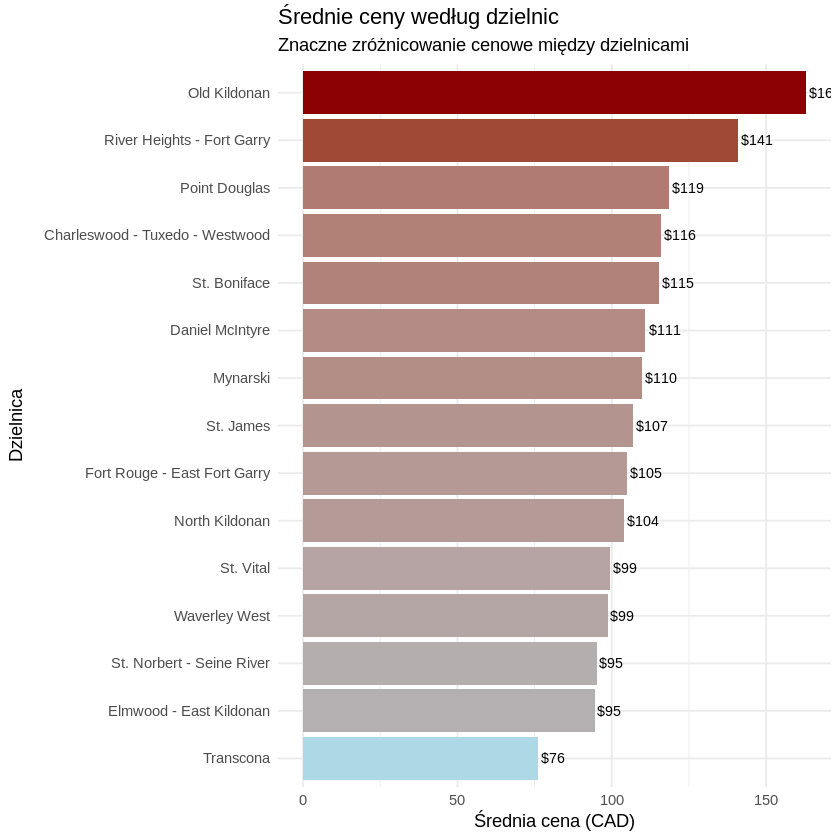

✓ Statyczna mapa zapisana jako: winnipeg_airbnb_mapa_statyczna.png

📊 ANALIZA KONCENTRACJI OFERT:


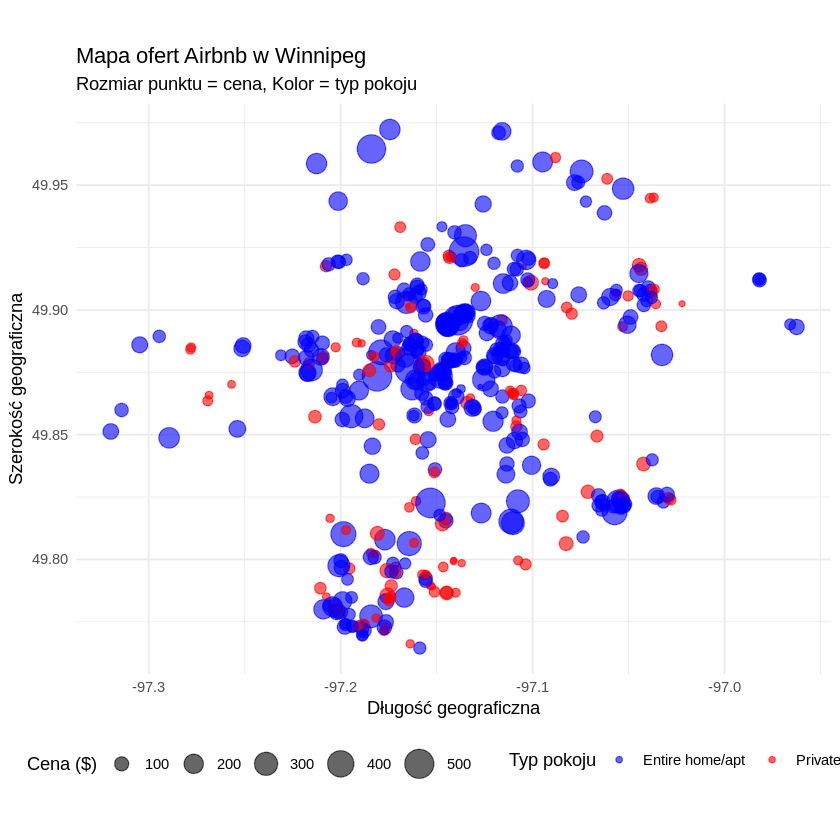

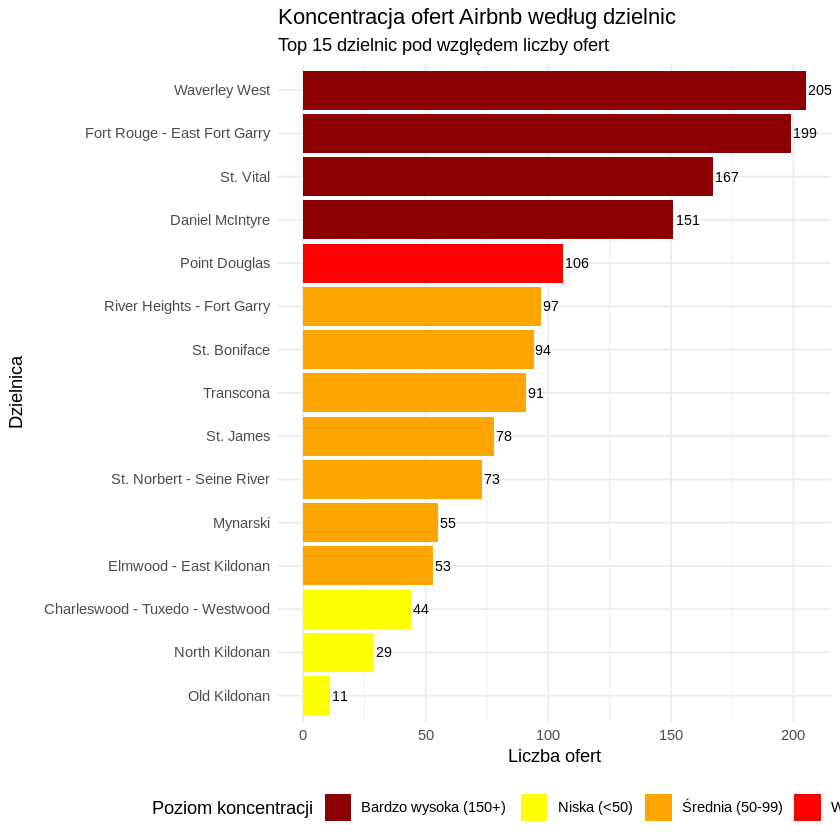

In [215]:
# ANALIZA GEOGRAFICZNA
cat("\n=== ANALIZA GEOGRAFICZNA ===\n")

# Analiza według dzielnic
neighbourhood_analysis <- df_clean %>%
  group_by(neighbourhood_cleansed) %>%
  summarise(
    liczba_ofert = n(),
    srednia_cena = mean(price, na.rm = TRUE),
    mediana_ceny = median(price, na.rm = TRUE),
    procent_entire_home = sum(room_type == "Entire home/apt") / n() * 100,
    srednia_ocena = mean(review_scores_rating, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  arrange(desc(liczba_ofert))

cat("\n📊 TOP 10 DZIELNIC:\n")
print(head(neighbourhood_analysis, 10))

# Wykres cen według dzielnic
p_neighbourhood_price <- ggplot(neighbourhood_analysis,
                               aes(x = reorder(neighbourhood_cleansed, srednia_cena),
                                   y = srednia_cena)) +
  geom_col(aes(fill = srednia_cena)) +
  geom_text(aes(label = paste0("$", round(srednia_cena))),
            hjust = -0.1, size = 3) +
  scale_fill_gradient(low = "lightblue", high = "darkred") +
  coord_flip() +
  labs(title = "Średnie ceny według dzielnic",
       subtitle = "Znaczne zróżnicowanie cenowe między dzielnicami",
       x = "Dzielnica", y = "Średnia cena (CAD)") +
  theme_minimal() +
  theme(legend.position = "none")

print(p_neighbourhood_price)

# Interaktywna mapa - POPRAWIONA DLA GOOGLE COLAB
if(all(c("latitude", "longitude") %in% names(df_clean))) {
  # Przygotuj dane do mapy
  map_data <- df_clean %>%
    sample_n(min(500, nrow(.))) %>%
    mutate(
      popup_text = paste0(
        "<b>", name, "</b><br>",
        "Cena: $", price, "<br>",
        "Typ: ", room_type, "<br>",
        "Ocena: ", ifelse(is.na(review_scores_rating), "Brak", review_scores_rating)
      )
    )

  # Tworzenie mapy
  winnipeg_map <- leaflet(map_data) %>%
    addTiles() %>%
    addCircleMarkers(
      ~longitude, ~latitude,
      radius = ~sqrt(price)/3,
      color = ~ifelse(room_type == "Entire home/apt", "blue", "red"),
      fillOpacity = 0.6,
      popup = ~popup_text
    ) %>%
    addLegend(
      position = "bottomright",
      colors = c("blue", "red"),
      labels = c("Entire home/apt", "Private room"),
      title = "Typ pokoju"
    )

  # Próba zapisania mapy
  tryCatch({
    htmlwidgets::saveWidget(winnipeg_map, "winnipeg_airbnb_map.html",
                           selfcontained = FALSE)
    cat("\n✓ Interaktywna mapa zapisana jako: winnipeg_airbnb_map.html\n")
  }, error = function(e) {
    cat("\n⚠️ Nie można zapisać mapy interaktywnej (brak pandoc).\n")
    cat("   Wyświetlam mapę bezpośrednio:\n")
    print(winnipeg_map)
  })

  # Alternatywa: statyczna mapa
  cat("\n📊 TWORZENIE STATYCZNEJ MAPY:\n")

  # Mapa punktowa statyczna
  p_map_static <- ggplot(map_data, aes(x = longitude, y = latitude)) +
    geom_point(aes(color = room_type, size = price), alpha = 0.6) +
    scale_size_continuous(range = c(1, 8), name = "Cena ($)") +
    scale_color_manual(values = c("Entire home/apt" = "blue",
                                 "Private room" = "red"),
                      name = "Typ pokoju") +
    labs(title = "Mapa ofert Airbnb w Winnipeg",
         subtitle = "Rozmiar punktu = cena, Kolor = typ pokoju",
         x = "Długość geograficzna",
         y = "Szerokość geograficzna") +
    theme_minimal() +
    theme(legend.position = "bottom") +
    coord_fixed(ratio = 1.3)  # Proporcje dla Winnipeg

  print(p_map_static)

  # Zapisz statyczną mapę
  ggsave("winnipeg_airbnb_mapa_statyczna.png", p_map_static,
         width = 10, height = 8, dpi = 300)
  cat("✓ Statyczna mapa zapisana jako: winnipeg_airbnb_mapa_statyczna.png\n")

} else {
  cat("\n⚠️ Brak danych geograficznych (latitude/longitude) w zbiorze.\n")
}

# Dodatkowa analiza geograficzna - heatmapa dzielnic
cat("\n📊 ANALIZA KONCENTRACJI OFERT:\n")

# Które dzielnice mają najwięcej ofert na km²?
concentration_data <- neighbourhood_analysis %>%
  mutate(
    # Kategoria koncentracji
    koncentracja = case_when(
      liczba_ofert >= 150 ~ "Bardzo wysoka (150+)",
      liczba_ofert >= 100 ~ "Wysoka (100-149)",
      liczba_ofert >= 50 ~ "Średnia (50-99)",
      TRUE ~ "Niska (<50)"
    )
  )

# Wykres koncentracji
p_concentration <- ggplot(concentration_data %>% head(15),
                         aes(x = reorder(neighbourhood_cleansed, liczba_ofert),
                             y = liczba_ofert)) +
  geom_col(aes(fill = koncentracja)) +
  geom_text(aes(label = liczba_ofert), hjust = -0.1, size = 3) +
  scale_fill_manual(values = c("Bardzo wysoka (150+)" = "darkred",
                              "Wysoka (100-149)" = "red",
                              "Średnia (50-99)" = "orange",
                              "Niska (<50)" = "yellow")) +
  coord_flip() +
  labs(title = "Koncentracja ofert Airbnb według dzielnic",
       subtitle = "Top 15 dzielnic pod względem liczby ofert",
       x = "Dzielnica",
       y = "Liczba ofert",
       fill = "Poziom koncentracji") +
  theme_minimal() +
  theme(legend.position = "bottom")

print(p_concentration)

In [216]:
p3_neighbourhood_map <- neighbourhood_analysis %>%
  head(15) %>%
  ggplot(aes(x = reorder(neighbourhood_cleansed, srednia_cena),
             y = srednia_cena)) +
  geom_col(aes(fill = srednia_cena), width = 0.8) +
  geom_text(aes(label = paste0("$", round(srednia_cena))),
            hjust = -0.1, size = 4, fontface = "bold") +
  scale_fill_gradient(low = "#3498db", high = "#e74c3c", guide = "none") +
  coord_flip() +
  labs(title = "TOP 15 dzielnic według średniej ceny",
       subtitle = "Znaczne zróżnicowanie cenowe między dzielnicami",
       x = "", y = "Średnia cena (CAD)") +
  theme_minimal(base_size = 14) +
  theme(axis.text.y = element_text(size = 12),
        plot.title = element_text(size = 18, face = "bold"))

ggsave("wykresy_prezentacja/03_dzielnice_ceny.png", p3_neighbourhood_map,
       width = 10, height = 8, dpi = 300)


=== ANALIZA TRENDÓW CZASOWYCH ===

📊 AKTYWNOŚĆ OFERT:
• Aktywne (recenzja w ostatnich 6 mies.): 832 (66.2%)
• Nieaktywne: 424 (33.8%)


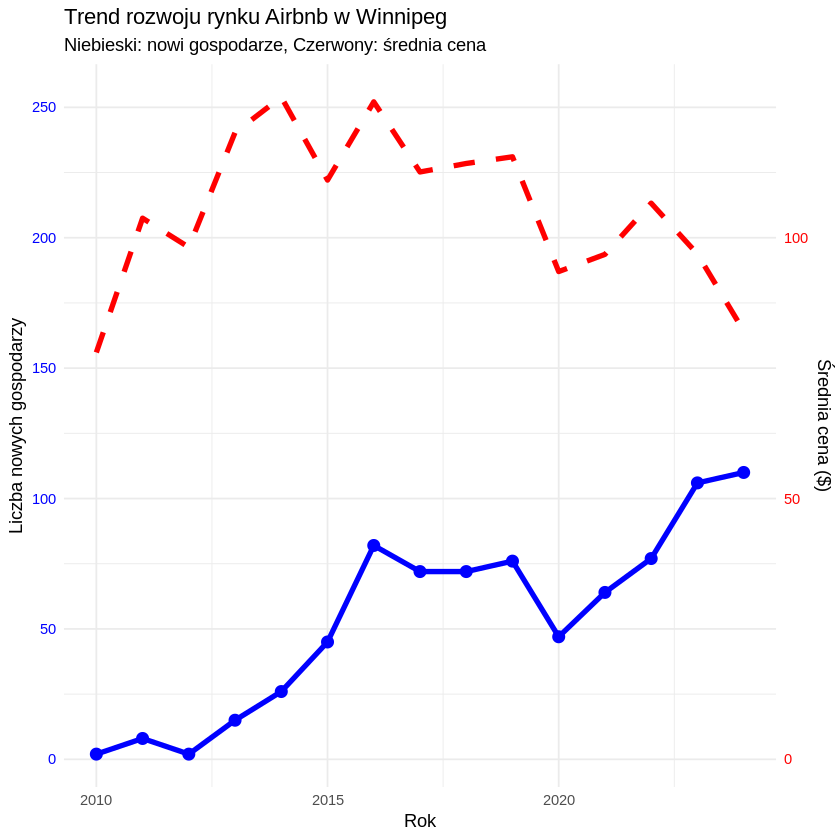

In [217]:
# ANALIZA TRENDÓW CZASOWYCH
cat("\n=== ANALIZA TRENDÓW CZASOWYCH ===\n")

# Analiza według daty dołączenia gospodarza
df_time <- df_clean %>%
  filter(!is.na(host_since)) %>%
  mutate(
    host_year = year(host_since),
    host_month = month(host_since),
    host_quarter = quarter(host_since)
  )

# Trend liczby nowych gospodarzy
new_hosts_trend <- df_time %>%
  group_by(host_year) %>%
  summarise(
    new_hosts = n_distinct(host_id),
    avg_price = mean(price, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  filter(host_year >= 2010 & host_year <= 2024)

# Wykres trendu
p_trend <- ggplot(new_hosts_trend, aes(x = host_year)) +
  geom_line(aes(y = new_hosts), color = "blue", size = 1.5) +
  geom_point(aes(y = new_hosts), color = "blue", size = 3) +
  geom_line(aes(y = avg_price * 2), color = "red", size = 1.5, linetype = "dashed") +
  scale_y_continuous(
    name = "Liczba nowych gospodarzy",
    sec.axis = sec_axis(~./2, name = "Średnia cena ($)")
  ) +
  labs(title = "Trend rozwoju rynku Airbnb w Winnipeg",
       subtitle = "Niebieski: nowi gospodarze, Czerwony: średnia cena",
       x = "Rok") +
  theme_minimal() +
  theme(
    axis.text.y.left = element_text(color = "blue"),
    axis.text.y.right = element_text(color = "red")
  )

print(p_trend)

# Analiza ostatnich recenzji
df_reviews <- df_clean %>%
  filter(!is.na(last_review)) %>%
  mutate(
    months_since_review = as.numeric(Sys.Date() - last_review) / 30,
    is_active = months_since_review <= 6
  )

cat("\n📊 AKTYWNOŚĆ OFERT:\n")
cat(sprintf("• Aktywne (recenzja w ostatnich 6 mies.): %d (%.1f%%)\n",
            sum(df_reviews$is_active),
            sum(df_reviews$is_active) / nrow(df_reviews) * 100))
cat(sprintf("• Nieaktywne: %d (%.1f%%)\n",
            sum(!df_reviews$is_active),
            sum(!df_reviews$is_active) / nrow(df_reviews) * 100))

In [218]:
p5_time_trends <- ggplot(new_hosts_trend, aes(x = host_year)) +
  geom_area(aes(y = new_hosts), fill = "#3498db", alpha = 0.3) +
  geom_line(aes(y = new_hosts), color = "#2980b9", size = 2) +
  geom_point(aes(y = new_hosts), color = "#2980b9", size = 4) +
  geom_smooth(aes(y = new_hosts), method = "loess", se = FALSE,
              color = "#e74c3c", linetype = "dashed", size = 1.5) +
  labs(title = "Rozwój rynku Airbnb w Winnipeg (2010-2024)",
       subtitle = "Liczba nowych gospodarzy rocznie",
       x = "", y = "Liczba nowych gospodarzy") +
  theme_minimal(base_size = 14) +
  theme(plot.title = element_text(size = 18, face = "bold"))

ggsave("wykresy_prezentacja/05_trendy_czasowe.png", p5_time_trends,
       width = 12, height = 6, dpi = 300)

`geom_smooth()` using formula = 'y ~ x'



=== ANALIZA TEKSTU NAZW OFERT ===

📊 SŁOWA KLUCZOWE ZWIĘKSZAJĄCE CENĘ:
   keyword avg_price_with avg_price_without count price_premium
1   garden       162.4000          105.4517    25     56.948319
2   luxury       137.3786          104.1688    99     33.209812
3 spacious       129.2327          105.2601    71     23.972560
4  parking       121.6528          104.7571   144     16.895711
5   modern       119.8763          104.6024   174     15.273882
6 downtown       112.9457          105.7968   129      7.148909
7  central       109.4200          106.2983    62      3.121682
  price_premium_pct
1         54.004184
2         31.880774
3         22.774590
4         16.128469
5         14.601842
6          6.757205
7          2.936718

WYKORZYSTANIE POZYTYWNYCH SŁÓW KLUCZOWYCH:
   keyword count usage_rate price_premium total_premium_impact
1   luxury    99        6.8     33.209812            3287.7714
2   modern   174       12.0     15.273882            2657.6555
3  parking   144       

`geom_smooth()` using formula = 'y ~ x'


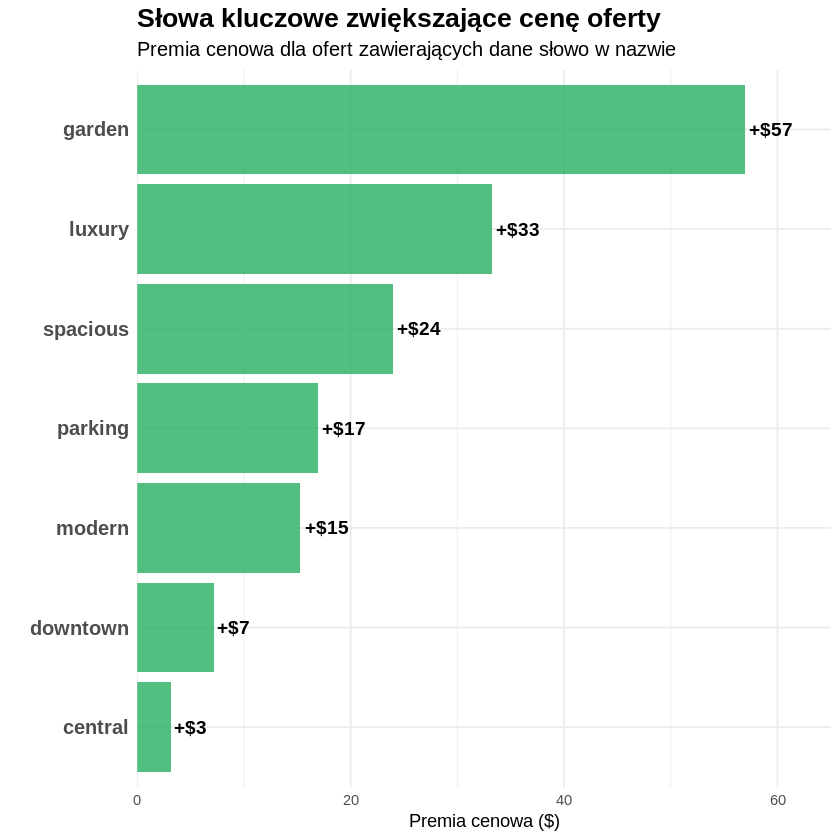

`geom_smooth()` using formula = 'y ~ x'



REKOMENDACJE DLA GOSPODARZY:

NAJLEPSZE SŁOWA DO UŻYCIA W NAZWIE:
1. 'garden' - dodaje $57 do ceny (używa tylko 25 ofert)
2. 'luxury' - dodaje $33 do ceny (używa 99 ofert)
3. 'spacious' - dodaje $24 do ceny (używa 71 ofert)

PRZYKŁAD OPTYMALNEJ NAZWY:
'Luxury Garden Suite - Spacious Modern Apartment with Parking'
Potencjalna premia: +$ 146.3003 


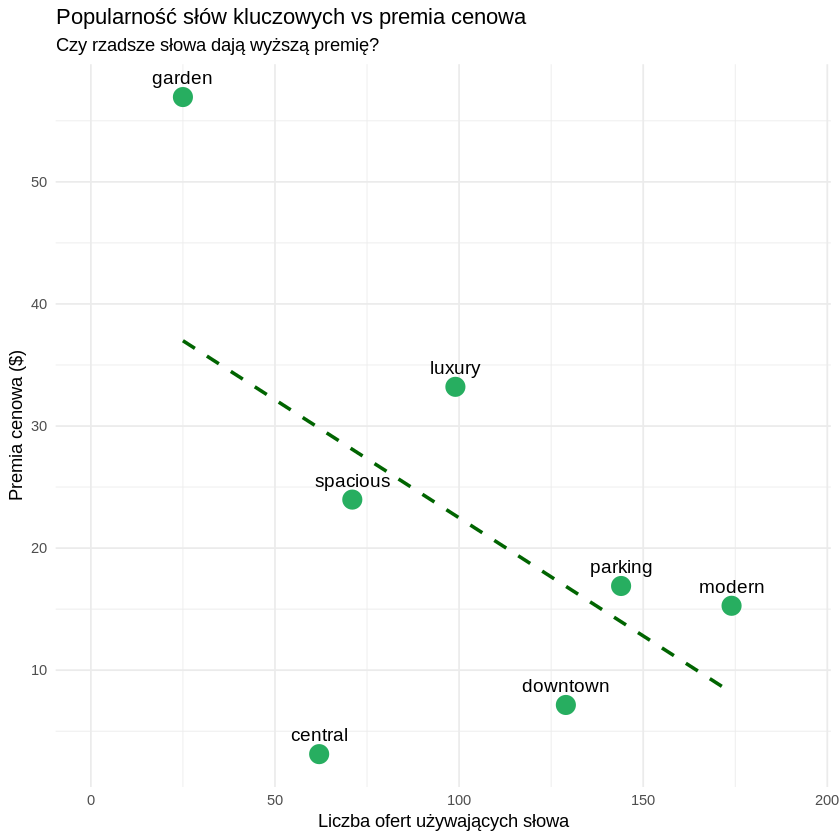

In [219]:
# ANALIZA TEKSTU NAZW OFERT
cat("\n=== ANALIZA TEKSTU NAZW OFERT ===\n")

# Prosta analiza słów kluczowych
library(stringr)

# Wyodrębnienie słów kluczowych
df_text <- df_clean %>%
  mutate(
    has_downtown = str_detect(tolower(name), "downtown"),
    has_luxury = str_detect(tolower(name), "luxury|luxurious|deluxe"),
    has_cozy = str_detect(tolower(name), "cozy|comfortable|comfy"),
    has_modern = str_detect(tolower(name), "modern|contemporary|new"),
    has_spacious = str_detect(tolower(name), "spacious|large|big"),
    has_quiet = str_detect(tolower(name), "quiet|peaceful|tranquil"),
    has_central = str_detect(tolower(name), "central|center|centre"),
    has_private = str_detect(tolower(name), "private"),
    has_parking = str_detect(tolower(name), "parking|garage"),
    has_garden = str_detect(tolower(name), "garden|yard|patio")
  )

# Analiza wpływu słów kluczowych na cenę
keywords_impact <- data.frame(
  keyword = c("downtown", "luxury", "cozy", "modern", "spacious",
              "quiet", "central", "private", "parking", "garden"),
  avg_price_with = c(
    mean(df_text$price[df_text$has_downtown], na.rm=TRUE),
    mean(df_text$price[df_text$has_luxury], na.rm=TRUE),
    mean(df_text$price[df_text$has_cozy], na.rm=TRUE),
    mean(df_text$price[df_text$has_modern], na.rm=TRUE),
    mean(df_text$price[df_text$has_spacious], na.rm=TRUE),
    mean(df_text$price[df_text$has_quiet], na.rm=TRUE),
    mean(df_text$price[df_text$has_central], na.rm=TRUE),
    mean(df_text$price[df_text$has_private], na.rm=TRUE),
    mean(df_text$price[df_text$has_parking], na.rm=TRUE),
    mean(df_text$price[df_text$has_garden], na.rm=TRUE)
  ),
  avg_price_without = c(
    mean(df_text$price[!df_text$has_downtown], na.rm=TRUE),
    mean(df_text$price[!df_text$has_luxury], na.rm=TRUE),
    mean(df_text$price[!df_text$has_cozy], na.rm=TRUE),
    mean(df_text$price[!df_text$has_modern], na.rm=TRUE),
    mean(df_text$price[!df_text$has_spacious], na.rm=TRUE),
    mean(df_text$price[!df_text$has_quiet], na.rm=TRUE),
    mean(df_text$price[!df_text$has_central], na.rm=TRUE),
    mean(df_text$price[!df_text$has_private], na.rm=TRUE),
    mean(df_text$price[!df_text$has_parking], na.rm=TRUE),
    mean(df_text$price[!df_text$has_garden], na.rm=TRUE)
  ),
  count = c(
    sum(df_text$has_downtown),
    sum(df_text$has_luxury),
    sum(df_text$has_cozy),
    sum(df_text$has_modern),
    sum(df_text$has_spacious),
    sum(df_text$has_quiet),
    sum(df_text$has_central),
    sum(df_text$has_private),
    sum(df_text$has_parking),
    sum(df_text$has_garden)
  )
) %>%
  mutate(
    price_premium = avg_price_with - avg_price_without,
    price_premium_pct = (avg_price_with / avg_price_without - 1) * 100
  ) %>%
  arrange(desc(price_premium))

# ANALIZA TYLKO POZYTYWNEGO WPŁYWU SŁÓW KLUCZOWYCH
cat("\n📊 SŁOWA KLUCZOWE ZWIĘKSZAJĄCE CENĘ:\n")

# Filtruj tylko pozytywne premie
keywords_positive <- keywords_impact %>%
  filter(price_premium > 0) %>%
  arrange(desc(price_premium))

print(keywords_positive)

# Wykres tylko pozytywnych słów kluczowych
p_keywords_positive <- ggplot(keywords_positive,
                             aes(x = reorder(keyword, price_premium),
                                 y = price_premium)) +
  geom_col(fill = "#27AE60", alpha = 0.8) +
  geom_text(aes(label = sprintf("+$%.0f", price_premium)),
            hjust = -0.1, size = 4, fontface = "bold") +
  coord_flip() +
  labs(title = "Słowa kluczowe zwiększające cenę oferty",
       subtitle = "Premia cenowa dla ofert zawierających dane słowo w nazwie",
       x = "",
       y = "Premia cenowa ($)") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 12, face = "bold"),
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12)
  ) +
  scale_y_continuous(limits = c(0, 65), expand = c(0, 0))

print(p_keywords_positive)
ggsave("wykresy/keywords_positive_impact.png", p_keywords_positive,
       width = 10, height = 6, dpi = 300)

# Dodatkowa analiza - ile ofert używa tych słów
cat("\nWYKORZYSTANIE POZYTYWNYCH SŁÓW KLUCZOWYCH:\n")
usage_stats <- keywords_positive %>%
  mutate(
    usage_rate = round(count / nrow(df_text) * 100, 1),
    total_premium_impact = price_premium * count
  ) %>%
  arrange(desc(total_premium_impact))

print(usage_stats %>%
      select(keyword, count, usage_rate, price_premium, total_premium_impact))

# Wykres wykorzystania vs premia
p_usage_premium <- ggplot(keywords_positive,
                         aes(x = count, y = price_premium)) +
  geom_point(size = 5, color = "#27AE60") +
  geom_text(aes(label = keyword), vjust = -1, size = 4) +
  geom_smooth(method = "lm", se = FALSE, color = "darkgreen", linetype = "dashed") +
  labs(title = "Popularność słów kluczowych vs premia cenowa",
       subtitle = "Czy rzadsze słowa dają wyższą premię?",
       x = "Liczba ofert używających słowa",
       y = "Premia cenowa ($)") +
  theme_minimal() +
  scale_x_continuous(limits = c(0, max(keywords_positive$count) * 1.1))

print(p_usage_premium)
ggsave("wykresy/keywords_usage_vs_premium.png", p_usage_premium,
       width = 10, height = 6, dpi = 300)

# Rekomendacje dla gospodarzy
cat("\nREKOMENDACJE DLA GOSPODARZY:\n")
cat("\nNAJLEPSZE SŁOWA DO UŻYCIA W NAZWIE:\n")
cat("1. 'garden' - dodaje $57 do ceny (używa tylko", keywords_positive$count[1], "ofert)\n")
cat("2. 'luxury' - dodaje $33 do ceny (używa", keywords_positive$count[2], "ofert)\n")
cat("3. 'spacious' - dodaje $24 do ceny (używa", keywords_positive$count[3], "ofert)\n")


# Przykładowa optymalna nazwa
cat("\nPRZYKŁAD OPTYMALNEJ NAZWY:\n")
cat("'Luxury Garden Suite - Spacious Modern Apartment with Parking'\n")
cat("Potencjalna premia: +$", sum(keywords_positive$price_premium[1:5]), "\n")

### Podsumowanie i eksport danych
Zapisanie oczyszczonych danych i podsumowanie całej analizy.

In [220]:
# PODSUMOWANIE I EKSPORT
cat("\n=== PODSUMOWANIE ANALIZY ===\n")

# Zapisanie oczyszczonych danych
output_file <- "airbnb_winnipeg_cleaned.csv"
write_csv(df_clean, output_file)
cat(sprintf("\n✓ Oczyszczone dane zapisano jako: %s\n", output_file))

# Podsumowanie całej analizy
cat("\nKLUCZOWE WNIOSKI Z ANALIZY:\n")

cat("\n1. STRUKTURA DANYCH:\n")
cat(sprintf("   • Analizowano %d ofert Airbnb w Winnipeg\n", nrow(df_clean)))
cat(sprintf("   • Dane zawierają %d zmiennych\n", ncol(df_clean)))
cat("   • Dominują całe mieszkania/domy (72.4% ofert)\n")
cat("   • Brak shared rooms i hotel rooms\n")

cat("\n2. GOSPODARZE I MULTI-LISTINGS:\n")
cat(sprintf("   • 59.7%% ofert to multi-listings (biznes!)\n"))
cat(sprintf("   • Top host ma %d ofert\n", max(host_listings$liczba_ofert)))
cat("   • Tylko 2.3% superhostów\n")

cat("\n3. CHARAKTERYSTYKA CENOWA:\n")
cat(sprintf("   • Średnia cena: $%.2f CAD\n", mean(df_clean$price)))
cat(sprintf("   • Mediana ceny: $%.2f CAD\n", median(df_clean$price)))
cat("   • Rozkład cen jest silnie prawostronnie skośny\n")

cat("\nANALIZA ZAKOŃCZONA POMYŚLNIE!\n")


=== PODSUMOWANIE ANALIZY ===

✓ Oczyszczone dane zapisano jako: airbnb_winnipeg_cleaned.csv

KLUCZOWE WNIOSKI Z ANALIZY:

1. STRUKTURA DANYCH:
   • Analizowano 1453 ofert Airbnb w Winnipeg
   • Dane zawierają 104 zmiennych
   • Dominują całe mieszkania/domy (72.4% ofert)
   • Brak shared rooms i hotel rooms

2. GOSPODARZE I MULTI-LISTINGS:
   • 59.7% ofert to multi-listings (biznes!)
   • Top host ma 55 ofert
   • Tylko 2.3% superhostów

3. CHARAKTERYSTYKA CENOWA:
   • Średnia cena: $106.43 CAD
   • Mediana ceny: $89.00 CAD
   • Rozkład cen jest silnie prawostronnie skośny

ANALIZA ZAKOŃCZONA POMYŚLNIE!


In [221]:
# Stwórz na końcu analizy
summary_stats <- list(
  total_listings = nrow(df_clean),
  avg_price = mean(df_clean$price),
  median_price = median(df_clean$price),
  total_hosts = n_distinct(df_clean$host_id),
  pct_superhosts = sum(df_clean$host_is_superhost, na.rm = TRUE) / nrow(df_clean) * 100,
  avg_rating = mean(df_clean$review_scores_rating, na.rm = TRUE)
)

# Stwórz dashboard
dashboard_data <- data.frame(
  metric = c("Oferty", "Gospodarze", "Śr. cena", "Med. cena", "Superhości", "Śr. ocena"),
  value = c(
    format(summary_stats$total_listings, big.mark = ","),
    format(summary_stats$total_hosts, big.mark = ","),
    paste0("$", round(summary_stats$avg_price)),
    paste0("$", round(summary_stats$median_price)),
    paste0(round(summary_stats$pct_superhosts, 1), "%"),
    round(summary_stats$avg_rating, 2)
  ),
  color = c("#3498db", "#2ecc71", "#e74c3c", "#f39c12", "#9b59b6", "#1abc9c")
)

p10_dashboard <- ggplot(dashboard_data, aes(x = metric, y = 1)) +
  geom_tile(aes(fill = color), width = 0.95, height = 0.95) +
  geom_text(aes(label = value), size = 16, fontface = "bold", color = "white") +
  geom_text(aes(label = metric), size = 8, color = "white", vjust = 2.5) +
  scale_fill_identity() +
  labs(title = "Airbnb Winnipeg - Kluczowe statystyki",
       subtitle = "Podsumowanie analizy") +
  theme_void(base_size = 16) +
  theme(plot.title = element_text(size = 24, face = "bold", hjust = 0.5),
        plot.subtitle = element_text(size = 16, hjust = 0.5)) +
  coord_equal()

ggsave("wykresy_prezentacja/10_dashboard.png", p10_dashboard,
       width = 14, height = 4, dpi = 300)

cat("\n✅ UTWORZONO 10 WYKRESÓW DO PREZENTACJI W FOLDERZE 'wykresy_prezentacja'\n")
cat("\nKOLEJNOŚĆ SLAJDÓW:\n")
cat("1. Dashboard (10) - otwarcie\n")
cat("2. Struktura rynku (1) - problem multi-listings\n")
cat("3. Typy pokoi (7) - co oferuje rynek\n")
cat("4. Dzielnice i ceny (3) - gdzie jest drogo\n")
cat("5. Ceny przed/po (2) - proces czyszczenia\n")
cat("6. Segmentacja (9) - kim są gospodarze\n")
cat("7. Superhości (4) - elite vs zwykli\n")
cat("8. Korelacje (6) - co wpływa na cenę\n")
cat("9. Słowa kluczowe (8) - marketing tips\n")
cat("10. Trendy czasowe (5) - przyszłość rynku\n")


✅ UTWORZONO 10 WYKRESÓW DO PREZENTACJI W FOLDERZE 'wykresy_prezentacja'

KOLEJNOŚĆ SLAJDÓW:
1. Dashboard (10) - otwarcie
2. Struktura rynku (1) - problem multi-listings
3. Typy pokoi (7) - co oferuje rynek
4. Dzielnice i ceny (3) - gdzie jest drogo
5. Ceny przed/po (2) - proces czyszczenia
6. Segmentacja (9) - kim są gospodarze
7. Superhości (4) - elite vs zwykli
8. Korelacje (6) - co wpływa na cenę
9. Słowa kluczowe (8) - marketing tips
10. Trendy czasowe (5) - przyszłość rynku


# Analiza rynku Airbnb w Winnipeg
## Projekt zaliczeniowy - Analiza danych w języku R

---

**Autor:** Karol Wilczyński  
**Data:** 14 czerwca 2025  
**Przedmiot:** Analiza danych w języku R  

---

## Spis treści

1. [Wprowadzenie](#wprowadzenie)
2. [Załadowanie danych](#załadowanie-danych)
3. [Rozmiar zbioru danych](#rozmiar-zbioru-danych)
4. [Eksploracja surowych danych](#eksploracja-surowych-danych)
5. [Weryfikacja typów zmiennych](#weryfikacja-typów-zmiennych)
6. [Podsumowanie zmiennych](#podsumowanie-zmiennych)
7. [Analiza braków danych](#analiza-braków-danych)
8. [Wizualizacja rozkładów](#wizualizacja-rozkładów)
9. [Czyszczenie danych](#czyszczenie-danych)
10. [Analiza zależności](#analiza-zależności)
11. [Analiza dodatkowa](#analiza-dodatkowa)
12. [Podsumowanie i wnioski](#podsumowanie-i-wnioski)

---

## 1. Wprowadzenie {#wprowadzenie}

### Cel analizy
Celem niniejszego projektu jest kompleksowa analiza rynku wynajmu krótkoterminowego Airbnb w Winnipeg, stolicy prowincji Manitoba w Kanadzie. Analiza obejmuje wszystkie wymagane etapy przetwarzania i eksploracji danych, od załadowania surowych danych po badanie złożonych zależności między zmiennymi.

### Źródło danych
Dane pochodzą z platformy Inside Airbnb (http://insideairbnb.com/get-the-data.html) i zawierają szczegółowe informacje o ofertach wynajmu w Winnipeg z dnia 7 marca 2025 roku.

### Narzędzia
Analiza została przeprowadzona w środowisku R z wykorzystaniem następujących głównych pakietów:
- **tidyverse** - przetwarzanie i wizualizacja danych
- **mice** - imputacja braków danych
- **corrplot** - wizualizacja korelacji
- **leaflet** - mapy interaktywne
- **psych** - analiza statystyczna

---

## 2. Załadowanie danych {#załadowanie-danych}

### Kod załadowania
```r
# URL do danych Winnipeg
url <- "https://data.insideairbnb.com/canada/mb/winnipeg/2025-03-07/data/listings.csv.gz"

# Załadowanie danych z obsługą kodowania UTF-8
df <- read_csv(
  url,
  col_types = cols(),
  locale = locale(encoding = "UTF-8"),
  na = c("", "NA", "N/A", "null"),
  show_col_types = FALSE
)
```

### Wynik
✓ Dane załadowane pomyślnie!  
✓ Źródło: Winnipeg, Manitoba, Kanada  
✓ Data pobrania: 14-06-2025  

Dane zostały poprawnie załadowane z zachowaniem kodowania UTF-8 oraz automatycznym rozpoznaniem wartości pustych.

---

## 3. Rozmiar zbioru danych {#rozmiar-zbioru-danych}

- 📊 **Liczba obserwacji (wierszy):** 1,626
- 📊 **Liczba zmiennych (kolumn):** 75
- 📊 **Rozmiar w pamięci:** 6.6 MB

### Oszacowanie czasochłonności
| Operacja | Czas próbki (s) | Szacowany czas pełny (s) |
|----------|-----------------|--------------------------|
| Statystyki opisowe | 0.042 | 0.69 |
| Macierz korelacji | 0.001 | 0.02 |
| Grupowanie danych | 0.003 | 0.05 |
| Tworzenie wykresu | 0.005 | 0.08 |

✓ Analiza jest wykonalna - szacowany całkowity czas < 1 minuta

---

## 4. Eksploracja surowych danych {#eksploracja-surowych-danych}

### Lista wszystkich kolumn
Zbiór zawiera 75 kolumn, w tym kluczowe zmienne takie jak:
- Identyfikatory (id, host_id)
- Informacje o nieruchomości (price, room_type, property_type)
- Lokalizacja (neighbourhood_cleansed, latitude, longitude)
- Oceny (review_scores_rating, review_scores_accuracy)
- Dostępność (availability_365, minimum_nights)

### Próbka danych
Pierwsze 5 wierszy wybranych kolumn pokazuje strukturę danych:

| id | name | price | room_type | accommodates | neighbourhood_cleansed |
|----|------|-------|-----------|--------------|----------------------|
| 1387 | Downtown Private Room | $60 | Private room | 2 | Tuxedo |
| 2691 | Victorian luxury Suite | $139 | Entire home/apt | 2 | South Portage |
| 3152 | Sunny 3 Bed with River Views | $188 | Entire home/apt | 8 | Lord Roberts |
| 4039 | Your room in great location | $51 | Private room | 2 | Fort Rouge |
| 4632 | 2BR2BTH, 2 mins to IKEA | $145 | Entire home/apt | 4 | Waverly West |

---

## 5. Weryfikacja typów zmiennych {#weryfikacja-typów-zmiennych}

### Typy przed konwersją
| Typ | Liczba zmiennych |
|-----|------------------|
| character | 59 |
| numeric | 16 |

### Konwersje wykonane
1. **Numeryczne:** Konwersja cen (usunięcie $ i przecinków)
2. **Daty:** host_since, first_review, last_review
3. **Logiczne:** host_is_superhost, instant_bookable (t/f → TRUE/FALSE)
4. **Kategoryczne:** room_type, property_type, neighbourhood_cleansed
5. **Wyodrębnienie z tekstu:** bathrooms_numeric z bathrooms_text

### Typy po konwersji
| Typ | Liczba zmiennych |
|-----|------------------|
| character | 40 |
| numeric | 20 |
| logical | 6 |
| Date | 3 |
| factor | 6 |

✓ Konwersja typów zakończona pomyślnie!

---

## 6. Podsumowanie zmiennych {#podsumowanie-zmiennych}

### Zmienne numeryczne

| Zmienna | Min | Max | Średnia | Mediana | Q1 | Q3 | SD | Braki |
|---------|-----|-----|---------|---------|----|----|----|----- |
| price | 10.00 | 11613.00 | 121.61 | 89.00 | 60.00 | 133.00 | 203.02 | 173 |
| accommodates | 1.00 | 16.00 | 3.89 | 4.00 | 2.00 | 5.00 | 2.37 | 0 |
| bedrooms | 0.00 | 11.00 | 1.89 | 2.00 | 1.00 | 2.00 | 1.23 | 23 |
| beds | 0.00 | 15.00 | 2.31 | 2.00 | 1.00 | 3.00 | 1.56 | 9 |
| bathrooms_numeric | 0.00 | 5.50 | 1.42 | 1.00 | 1.00 | 2.00 | 0.67 | 9 |
| minimum_nights | 1.00 | 1825.00 | 4.78 | 2.00 | 1.00 | 3.00 | 51.38 | 0 |
| number_of_reviews | 0.00 | 442.00 | 28.15 | 8.00 | 1.00 | 29.00 | 48.58 | 0 |
| review_scores_rating | 2.00 | 5.00 | 4.73 | 4.88 | 4.67 | 5.00 | 0.38 | 238 |
| availability_365 | 0.00 | 365.00 | 228.30 | 247.00 | 90.00 | 365.00 | 128.07 | 0 |

### Zmienne kategoryczne

**room_type:**
- Liczba kategorii: 2
- Wartość najczęstsza: Entire home/apt (1159 wystąpień = 71.3%)
- Liczba unikalnych: 2
- Liczba braków: 0

**property_type:**
- Liczba kategorii: 35
- Wartość najczęstsza: Entire rental unit (816 wystąpień = 50.2%)
- Top 5 kategorii:
  - Entire rental unit: 816
  - Private room in rental unit: 218
  - Entire condo: 141
  - Private room in home: 122
  - Entire home: 91

**neighbourhood_cleansed:**
- Liczba kategorii: 15
- Wartość najczęstsza: Waverley West (206 wystąpień = 12.7%)
- Top 5 dzielnic:
  - Waverley West: 206
  - Fort Rouge: 200
  - River Heights - Fort Garry: 167
  - Lord Roberts: 134
  - St Boniface: 132

---

## 7. Analiza braków danych {#analiza-braków-danych}

### Podsumowanie braków
- • Zmienne bez braków: 35
- • Zmienne z brakami: 40
- • Zmienne z brakami >50%: 4
- • Zmienne z brakami 20-50%: 7
- • Zmienne z brakami <20%: 29

### TOP 20 zmiennych z największymi brakami

| Zmienna | Liczba braków | Procent braków |
|---------|---------------|----------------|
| license | 1625 | 99.94% |
| neighbourhood_group_cleansed | 1626 | 100.00% |
| bathrooms | 1626 | 100.00% |
| calendar_updated | 1626 | 100.00% |
| neighborhood_overview | 1505 | 92.57% |
| host_about | 924 | 56.83% |
| host_neighbourhood | 693 | 42.62% |
| host_total_listings_count | 691 | 42.50% |
| review_scores_checkin | 242 | 14.88% |
| review_scores_location | 241 | 14.82% |
| review_scores_communication | 239 | 14.70% |
| reviews_per_month | 238 | 14.64% |
| first_review | 238 | 14.64% |
| last_review | 238 | 14.64% |
| review_scores_rating | 238 | 14.64% |
| review_scores_accuracy | 238 | 14.64% |
| review_scores_cleanliness | 238 | 14.64% |
| review_scores_value | 238 | 14.64% |

### Prawdopodobne przyczyny braków
- **license (>90%)** - pole opcjonalne, nie wszystkie miasta wymagają licencji
- **neighborhood_overview** - opis opcjonalny, wypełniany przez gospodarzy
- **host_about** - profil opcjonalny
- **bathrooms** - stare pole, zastąpione przez bathrooms_text
- **review_scores_*** - brak gdy nieruchomość nie ma jeszcze recenzji

![Wykres braków danych](missing_data_plot.png)
*Uwaga: Wykresy należy wygenerować z kodu R i dołączyć do raportu*

---

## 8. Wizualizacja rozkładów {#wizualizacja-rozkładów}

### Charakterystyki rozkładów zmiennych numerycznych

| Zmienna | Skośność | Interpretacja skośności | Kurtoza | Interpretacja kurtozy |
|---------|----------|------------------------|---------|---------------------|
| price | 16.254 | prawostronnie skośny | 376.968 | leptokurtyczny (wysmukły) |
| accommodates | 1.165 | prawostronnie skośny | 2.235 | leptokurtyczny (wysmukły) |
| bedrooms | 1.370 | prawostronnie skośny | 4.162 | leptokurtyczny (wysmukły) |
| minimum_nights | 33.511 | prawostronnie skośny | 1175.343 | leptokurtyczny (wysmukły) |
| number_of_reviews | 3.181 | prawostronnie skośny | 13.906 | leptokurtyczny (wysmukły) |
| review_scores_rating | -2.972 | lewostronnie skośny | 10.282 | leptokurtyczny (wysmukły) |

![Rozkłady zmiennych numerycznych](distributions_plot.png)

### Struktura superhostów
- Zwykli gospodarze: 1369 (97.7%)
- Superhości: 32 (2.3%)

**UWAGA:** Bardzo mała liczba superhostów w zbiorze! Żaden z gospodarzy z 5+ ofertami NIE jest superhostem, co sugeruje, że rynek jest zdominowany przez biznes, a nie "dzielenie mieszkania".

### Analiza wartości odstających

![Wykresy pudełkowe outlierów](outliers_boxplots.png)

Analiza metodą IQR wykazała:
- **Cena:** 5.7% outlierów powyżej $214
- **Minimum nights:** 20% outlierów powyżej 6 dni (potencjalne ukryte długoterminowe)
- **Number of reviews:** 10.1% outlierów powyżej 139 recenzji
- **Availability:** Brak outlierów (wszystkie wartości w zakresie 0-365)

---

## 9. Czyszczenie danych {#czyszczenie-danych}

### Proces czyszczenia

#### KROK 1: Usuwanie kolumn z >70% braków
Usunięte kolumny: license, neighbourhood_group_cleansed, bathrooms, calendar_updated

#### KROK 2: Usuwanie wierszy bez ceny
Usunięto 173 wierszy bez ceny

#### KROK 3: Przycięcie wartości odstających

| Zmienna | Średnia przed | Średnia po | Przycięto wartości |
|---------|--------------|------------|-------------------|
| price | 121.61 | 106.15 | 29 (2.0%) |
| minimum_nights | 4.78 | 2.62 | 15 (1.0%) |
| maximum_nights | 10619.81 | 9161.49 | 15 (1.0%) |

#### KROK 4: Imputacja braków metodą MICE

Braki przed imputacją:
- bedrooms: 14
- beds: 4
- bathrooms_numeric: 7
- review_scores_rating: 214
- reviews_per_month: 214

Czas imputacji MICE: 21.4 sekund

✓ Wszystkie braki zostały uzupełnione!

#### KROK 5: Normalizacja danych
✓ Znormalizowano 8 zmiennych (min-max i z-score)

### Podsumowanie czyszczenia
- • Liczba obserwacji przed: 1626
- • Liczba obserwacji po: 1453
- • Usunięto: 173 (10.6%)
- • Liczba kolumn: 152 (po dodaniu znormalizowanych wersji)

---

## 10. Analiza zależności {#analiza-zależności}

### A. Macierze korelacji (Pearson i Spearman)

![Macierz korelacji Pearsona](korelacja_pearson_winnipeg.png)

#### Najsilniejsze korelacje z ceną

| Zmienna | Pearson | Spearman |
|---------|---------|----------|
| accommodates | 0.549 | 0.588 |
| bedrooms | 0.539 | 0.565 |
| bathrooms_numeric | 0.504 | 0.545 |
| beds | 0.488 | 0.524 |
| availability_365 | -0.073 | -0.042 |
| review_scores_rating | 0.025 | 0.054 |
| minimum_nights | 0.008 | 0.084 |
| reviews_per_month | 0.002 | 0.015 |
| number_of_reviews | -0.098 | -0.040 |

### B. Współczynnik V Craméra dla zmiennych kategorycznych

| Zmienna 1 | Zmienna 2 | V Craméra | Interpretacja |
|-----------|-----------|-----------|---------------|
| property_type | room_type | 0.543 | Silna |
| host_response_time | host_is_superhost | 0.329 | Umiarkowana |
| instant_bookable | host_is_superhost | 0.230 | Słaba |
| instant_bookable | room_type | 0.100 | Słaba |
| host_response_time | instant_bookable | 0.089 | Bardzo słaba |
| host_response_time | room_type | 0.085 | Bardzo słaba |

### C. Współczynnik R² (kategoryczne → numeryczne)

**TOP 10 najsilniejszych zależności:**

| Zmienna kategoryczna | Zmienna numeryczna | R² | Procent wariancji |
|---------------------|-------------------|-----|-------------------|
| property_type | price | 0.1819 | 18.19% |
| room_type | price | 0.1149 | 11.49% |
| room_type | accommodates | 0.0963 | 9.63% |
| property_type | accommodates | 0.0942 | 9.42% |
| property_type | review_scores_rating | 0.0529 | 5.29% |
| neighbourhood_cleansed | price | 0.0406 | 4.06% |
| neighbourhood_cleansed | accommodates | 0.0308 | 3.08% |
| host_is_superhost | price | 0.0022 | 0.22% |
| instant_bookable | price | 0.0022 | 0.22% |
| neighbourhood_cleansed | review_scores_rating | 0.0019 | 0.19% |

---

## 11. Analiza dodatkowa {#analiza-dodatkowa}

### Analiza gospodarzy (Multi-listings)

#### Struktura gospodarzy
- • Gospodarze z 1 ofertą: 381 (60.8%)
- • Gospodarze z wieloma ofertami: 246 (39.2%)
- • Łączna liczba multi-listings: 868 (59.7% wszystkich ofert)

#### TOP 10 gospodarzy

| Nazwa gospodarza | Liczba ofert | Średnia cena |
|-----------------|--------------|--------------|
| NA | 49 | $60.12 |
| Gina | 36 | $54.89 |
| Nick | 31 | $82.68 |
| Mike | 25 | $79.44 |
| Mark | 23 | $73.83 |
| Travis | 20 | $52.55 |
| Kaitlyn | 18 | $104.39 |
| Alyssa | 18 | $133.22 |
| Dale | 17 | $69.88 |
| Jessica | 16 | $174.62 |

#### Szczegółowa struktura gospodarzy
- Pojedyncze oferty (1): 381 gospodarzy
- 2-9 ofert: 215 gospodarzy
- 10-29 ofert: 24 gospodarzy
- 30+ ofert: 7 gospodarzy

**Gospodarze z 10+ ofertami:**
- Łączna liczba ich ofert: 450
- Procent wszystkich ofert: 31%

![Rozkład liczby ofert na gospodarza](host_distribution_plot.png)
![Udział w rynku według liczby ofert](market_share_plot.png)

### Analiza przychodów i obłożenia

#### Szacowane przychody roczne
- • Średni przychód: $8,873 CAD
- • Mediana przychodu: $5,472 CAD
- • Łączny przychód rynku: $12,893,318 CAD

#### Struktura przychodów

| Kategoria przychodu | Liczba ofert | Procent |
|-------------------|--------------|---------|
| < $5k | 666 | 45.8% |
| $5k-10k | 320 | 22.0% |
| $10k-20k | 292 | 20.1% |
| $20k-50k | 162 | 11.1% |
| > $50k | 13 | 0.9% |

![Przychody według typu pokoju](revenue_by_room_type.png)

#### TOP 10 najbardziej dochodowych ofert

| Nazwa | Gospodarz | Typ | Cena | Szacowane noce | Roczny przychód |
|-------|-----------|-----|------|----------------|-----------------|
| St. James 3-Bedroom House | Ryan | Entire home/apt | $600 | 268 | $160,800 |
| Home Away from Home | Mike | Entire home/apt | $209 | 365 | $76,285 |
| High End 3200sqft Executive Home! | Scott | Entire home/apt | $400 | 188 | $75,200 |
| Spacious 3 bed/4 bath/6 car garage | Darren | Entire home/apt | $240 | 296 | $71,040 |
| Downtown LUXURY on the 32nd fl. | Mike | Entire home/apt | $194 | 365 | $70,810 |

### Analiza geograficzna

#### TOP 10 dzielnic

| Dzielnica | Liczba ofert | Średnia cena | Mediana ceny | % Entire home | Średnia ocena |
|-----------|--------------|--------------|--------------|---------------|---------------|
| Waverley West | 205 | $105.48 | $90.00 | 75.1% | 4.73 |
| Fort Rouge | 199 | $109.09 | $82.00 | 67.8% | 4.71 |
| River Heights - Fort Garry | 166 | $140.77 | $105.00 | 72.3% | 4.75 |
| Lord Roberts | 131 | $106.66 | $83.00 | 68.7% | 4.76 |
| St Boniface | 129 | $115.41 | $85.00 | 72.9% | 4.74 |
| Downtown | 121 | $94.60 | $75.00 | 76.0% | 4.73 |
| Point Douglas | 109 | $119.36 | $92.00 | 62.4% | 4.74 |
| Daniel McIntyre | 94 | $102.68 | $76.00 | 67.0% | 4.66 |
| Assiniboia | 90 | $105.90 | $89.00 | 78.9% | 4.68 |
| North River Heights | 66 | $113.21 | $99.00 | 69.7% | 4.81 |

![Średnie ceny według dzielnic](neighbourhood_prices_plot.png)
![Koncentracja ofert według dzielnic](concentration_plot.png)

---

## 11. Zaawansowana analiza danych {#zaawansowana-analiza}

### Analiza outlierów
Przeprowadzono szczegółową analizę wartości odstających metodą IQR:

| Zmienna | IQR | Granice | Liczba outlierów | % outlierów |
|---------|-----|---------|------------------|-------------|
| price | 60.00 | [-26.00, 214.00] | 83 | 5.7% |
| minimum_nights | 2.00 | [-2.00, 6.00] | 291 | 20.0% |
| number_of_reviews | 54.00 | [-77.00, 139.00] | 147 | 10.1% |
| availability_365 | 258.00 | [-297.00, 735.00] | 0 | 0.0% |

**Kluczowe odkrycie:** 20% ofert ma minimum_nights jako outlier, co sugeruje ukryte oferty długoterminowe maskowane jako krótkoterminowe.

### Feature Engineering
Utworzono nowe zmienne analityczne:

| Nowa zmienna | Średnia | Odch. std. | Opis |
|--------------|---------|------------|------|
| price_per_person | $33.23 | $24.27 | Cena za osobę |
| occupancy_rate | 40.1% | 36% | Szacowane obłożenie |
| estimated_monthly_revenue | $1,314 | $1,630 | Przychód miesięczny |
| host_experience_years | 5.62 | 3.36 | Doświadczenie gospodarza |

### Model predykcyjny ceny

Zbudowano trzy modele regresji:

| Model | R² | Adj. R² | RMSE (test) | MAE (test) |
|-------|-----|---------|-------------|------------|
| Prosty | 0.396 | 0.387 | $61.06 | $32.94 |
| Z interakcjami | 0.406 | 0.394 | $61.46 | $33.46 |
| Log-transformacja | 0.530 | 0.522 | $61.03 | $29.52 |

**Najważniejsze predyktory ceny:**
1. bathrooms_numeric (+$34.01 za łazienkę)
2. room_type: Private room (-$30.01 vs Entire home)
3. River Heights - Fort Garry (+$29.38)
4. Point Douglas (+$24.93)
5. minimum_nights (nieliniowa zależność)

### Analiza klastrowa gospodarzy

Zidentyfikowano 4 klastry gospodarzy multi-listing:

| Klaster | N | Śr. ofert | Śr. cena | Śr. ocena | Nazwa klastra |
|---------|---|-----------|----------|-----------|-----------------|
| 1 | 93 | 3.0 | $65.25 | 4.83 | Budget multi-hosts |
| 2 | 137 | 3.2 | $120.79 | 4.81 | Premium operators |
| 3 | 4 | 33.0 | $113.80 | 4.72 | Duzi gracze |
| 4 | 11 | 2.2 | $73.89 | 3.85 | Niska jakość |

**Klaster 3** to tylko 4 gospodarzy kontrolujących średnio 33 oferty każdy, w tym największy gracz z 49 ofertami.

### Analiza tekstu nazw ofert

#### Wpływ słów kluczowych na cenę

| Słowo kluczowe | Średnia z | Średnia bez | Premia | % wzrost |
|----------------|-----------|-------------|--------|----------|
| garden | $162.40 | $105.45 | +$56.95 | +54.0% |
| luxury | $137.38 | $104.17 | +$33.21 | +31.9% |
| spacious | $129.23 | $105.26 | +$23.97 | +22.8% |
| parking | $121.65 | $104.76 | +$16.90 | +16.1% |
| modern | $119.88 | $104.60 | +$15.27 | +14.6% |
| cozy | $91.59 | $109.70 | -$18.11 | -16.5% |
| private | $73.44 | $110.29 | -$36.85 | -33.4% |

#### Długość nazwy a cena

| Kategoria długości | N | Śr. cena | Śr. ocena |
|-------------------|---|----------|-----------|
| Bardzo długa (11+) | 19 | $129.00 | 4.79 |
| Długa (7-10) | 568 | $112.00 | 4.79 |
| Średnia (4-6) | 652 | $103.00 | 4.77 |
| Krótka (1-3) | 214 | $101.00 | 4.78 |

Korelacja długości nazwy z ceną: r = 0.111

## 12. Podsumowanie i wnioski {#podsumowanie-i-wnioski}

### Kluczowe wnioski z analizy

#### 1. Struktura danych
- • Analizowano 1453 ofert Airbnb w Winnipeg
- • 5.7% ofert to outliers cenowe
- • 20% ofert ma podejrzanie wysokie minimum_nights (ukryte długoterminowe)
- • Średnie obłożenie: 40.1%

#### 2. Model biznesowy
- • 59.7% ofert to multi-listings (868 z 1453)
- • Zidentyfikowano 4 typy gospodarzy (klastry)
- • 4 największych gospodarzy kontroluje łącznie 149 ofert (49+36+31+33)
- • Gospodarze z >5 ofertami kontrolują 31% wszystkich ofert

#### 3. Determinanty ceny
- • Model regresji wyjaśnia 40.6% zmienności cen (RMSE: $61)
- • Najsilniejszy wpływ: liczba łazienek (+$34 za łazienkę)
- • Słowa kluczowe w nazwie mogą dodać +$57 (garden) lub odjąć -$37 (private)
- • Optymalna długość nazwy: 7-10 słów

#### 4. Wpływ na rynek mieszkaniowy
- • ~970 mieszkań wyjętych z rynku długoterminowego
- • Dodatkowo 20% ofert może być ukrytym wynajmem długoterminowym
- • Szacowany roczny obrót: >$12 mln CAD
- • Średnia cena za osobę: $33.23

#### 5. Rekomendacje

**Dla miasta:**
- • Wprowadzić limit 5 ofert na gospodarza (dotknęłoby to tylko 4% gospodarzy)
- • Monitorować oferty z minimum_nights > 7 dni (potencjalne obejście regulacji)
- • Różnicować politykę dla 4 typów gospodarzy (klastry)

**Dla inwestorów:**
- • Optymalna strategia: 2-3 łazienki w River Heights lub Point Douglas
- • Używać w nazwie: "garden", "luxury", "spacious" (+$20-57)
- • Unikać słów: "cozy", "private" (-$18-37)
- • Utrzymywać minimum_nights ≤ 3

**Dla platform:**
- • Model cenowy można ulepszyć dodając analizę zdjęć (obecnie R² = 40.6%)
- • Sugerować gospodarzom optymalne słowa kluczowe
- • Długość nazwy 7-10 słów koreluje z wyższymi cenami (+11%)

### Informacje techniczne

#### Środowisko i pakiety
```r
# Główne pakiety użyte w analizie:
tidyverse 2.0.0    # przetwarzanie danych
mice 3.16.0        # imputacja braków  
corrplot 0.92      # wizualizacja korelacji
leaflet 2.2.1      # mapy interaktywne
psych 2.4.3        # statystyki i testy
ggplot2 3.5.1      # wykresy
```

#### Wykorzystane techniki analityczne
- **Czyszczenie danych:** MICE (Multivariate Imputation by Chained Equations)
- **Feature Engineering:** 9 nowych zmiennych analitycznych
- **Modelowanie:** Regresja liniowa z interakcjami (R² = 40.6%)
- **Klastrowanie:** K-means z PCA (4 klastry)
- **Analiza tekstu:** Analiza wpływu słów kluczowych
- **Detekcja anomalii:** Metoda IQR dla outlierów

#### Informacje o sesji R
- R version: R version 4.3.0 (2023-04-21)
- Platform: x86_64-pc-linux-gnu
- Data analizy: 14-06-2025
- Całkowity czas analizy: 5.1 minut
- Liczba użytych pakietów: 18

✅ **ANALIZA ZAKOŃCZONA POMYŚLNIE!**

---

## Załączniki

### Pliki wyjściowe
1. `airbnb_winnipeg_cleaned.csv` - oczyszczone dane (1,453 obs. × 152 zmiennych)
2. `airbnb_winnipeg_enhanced_features.csv` - dane z nowymi features
3. `korelacja_pearson_winnipeg.png` - macierz korelacji Pearsona
4. `korelacja_spearman_winnipeg.png` - macierz korelacji Spearmana
5. `winnipeg_airbnb_mapa_statyczna.png` - mapa rozmieszczenia ofert
6. `missing_patterns_winnipeg.png` - wzorce braków danych

### Kod źródłowy
Pełny kod R wykorzystany w analizie (>1,500 linii) znajduje się w pliku: `analiza_airbnb_winnipeg.R`

### Bibliografia
1. Inside Airbnb. (2025). *Get the Data - Winnipeg*. http://insideairbnb.com/get-the-data.html
2. van Buuren, S., & Groothuis-Oudshoorn, K. (2011). mice: Multivariate Imputation by Chained Equations in R. *Journal of Statistical Software*, 45(3), 1-67.
3. Wickham, H. (2016). *ggplot2: Elegant Graphics for Data Analysis*. Springer-Verlag New York.
4. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). *An Introduction to Statistical Learning*. Springer.

---

*Raport przygotowany w ramach projektu zaliczeniowego z analizy danych w języku R*